<h1>Chess Game Data Analysis</h1> 
<h3> By Bobby Becker </h3>

Link: https://ogreowl.github.io/chess-analysis/


<h2> Problem </h2>
The main problem we'll be solving is how skill-level correlates to other features in a chess game, and if we can use this information to predict a player's approximate skill-level. This can already be done with advanced models, but we'll be using simpler models to try and make these predictions with less features. With simpler models, we can make predictions that are more interpretable and computationally efficient. 

In addtion, we'll be looking at how different time controls affect other features, and how different types of chess players — Grandmasters, average players, and AI — differ from one another.

In the real world, this type of analysis could be used for chess-coaching, AI-coaching in online Chess games, tournament organization, and even in the future, AI-agent based chessbots.

I also believe that this problem holds particular importance due to Chess's unique role in the history of AI research. In 1997, IBM's Deep Blue defeated Garry Kasparov in a historic match. Since then, chess has become a standard game to benchmark different cababilities of AI. While this notebook will focus more on traditional data science analysis, this type of research is import for informing how AI models are developed in this domain.

<h2>Summary</h2>

This project looks at three chess datasets to analyze patterns in chess play across different levels of expertise, comparing thousands of modern online games from Lichess.org with games from legendary grandmasters (including Bobby Fischer, Garry Kasparov, and Paul Morphy), as well as AI games generated by Stockfish. Using statistical analysis and visualizations, we look at how factors like player ratings influence game length, opening choices, and win rates, while also seeing how chess strategy differs between amateur players, famous grandmasters, and artificial intelligence.

<h2>Data</h2>
This project incorporates three datasets of chess games: 

* Games collected from the online platform 'Lichess'

* Chess games played by famous Grand Masters

* AI chess games played by Stockfish

The first two datasets were both downloaded through Kaggle:

* https://www.kaggle.com/datasets/datasnaek/chess

* https://www.kaggle.com/datasets/liury123/chess-game-from-12-top-players

The third dataset was generated through our own code using the Stockfish Python API:

* Code: ai_games.ipynb

* API: https://pypi.org/project/stockfish/


<h2>Objectives</h2>
For these datasets, I am hoping to answer the following questions:

1st: How does the player rankings affect the distribution of other features?

* This is important as it tells us if the skill-level of a chess games affect player choices in a way that can be quantifiably measured

2nd. How do the differences in the player rankings affect the game outcomes?

* This is interesting as it tells us the degree in which a player's ranking gives them an advantage in terms of likelihood to win.

3rd. How do the different time controls affect game lengths? How do the game lengths correlate to the end condition? (draw, out of time, etc)

* This will tell us if different time controls have potentially unexpected affects in terms of the outcome of the game. 

4th. How do game lengths correlate with player rankings across different opening moves? (3-variable comparison)

* This will be interesting because it will be a level deeper of granularity than our other analysis: we'll look at, for each opening move, how the game lengths correlate to to player rankings to see if there are any differences in the correlation depending on the first-move chosen.

5th. What are the differences between how average players play (dataset 1) compared to Grandmasters & AI?

* These stats will tell us how high-ranking chess players approach the game as compared to an average, casual online player. 

<h2>Structure</h2>
This file is organized into the following sections:

**ETL of our Main Dataset**

* Loading & preparing dataset 1 (Lichess games)

* Selecting main datapoint

* Printing & visualizing statistics

**EDA of our Main Dataset**

* Tracking correlations across variables

* Visualizing deeper properties

* Answering questions 1, 2, and 3.

**Incorporating Other Datasets**

* Loading, preparing, and analyzing datasets 2 & 3

* Exploring statistical differences across datasets

* Answering questions 4 and 5. 

**Model Exploration**

In this section, I'll identify, explain, and analyze three possible ML to use on our data:

* Model 1: predicting player rankings based on moves, winner, and game outcomes via regression

* Model 2: predicting if a player is an AI or not via classification

* Model 3: predicting if a player is an AI via LSTM neural network

<h2> Additional Recourses </h2>

Learn more about Stockfish here: https://stockfishchess.org/, or through their github: https://github.com/official-stockfish/Stockfish. And you can also read more about the history of AI and chess here: https://builtin.com/artificial-intelligence/chess-ai

Learn more about this type of Chess data analysis, I would recommend this paper: https://arxiv.org/abs/2304.11425 . It provides information about advanced data visualization of chess games in certain positions.

To learn about some state of the art research, I would recommend looking at this paper by Google Deepmind: https://arxiv.org/abs/2402.04494 . This paper effectively makes a chess AI that is able to play at advanced levels using GPT (transformers), unlike traditional chess engines that use search trees. 

Even more recent research is trying to deploy AI-agents to run and evaluate their own models, such as this Kaggle compeititon: https://www.kaggle.com/competitions/fide-google-efficiency-chess-ai-challenge . 




In [470]:
"""Since I use plotly for this project, I imported a special libary to help me render the visualizations as static images, so that
they could be shown through GitHub Pages"""


import plotly.io as pio
pio.renderers.default = "png"
pio.kaleido.scope.default_scale = 3

<h2>Part One: ETL of our main dataset</h2>

First, let's load in our dataset, a csv file saved to our directory. We'll being using the python library pandas to do this, which you can learn about more here: https://pandas.pydata.org/docs/getting_started/index.html

In [471]:
import pandas as pd

"""The data"""
df = pd.read_csv('games.csv')

print(df.head(5))

         id  rated    created_at  last_move_at  turns victory_status winner  \
0  TZJHLljE  False  1.504210e+12  1.504210e+12     13      outoftime  white   
1  l1NXvwaE   True  1.504130e+12  1.504130e+12     16         resign  black   
2  mIICvQHh   True  1.504130e+12  1.504130e+12     61           mate  white   
3  kWKvrqYL   True  1.504110e+12  1.504110e+12     61           mate  white   
4  9tXo1AUZ   True  1.504030e+12  1.504030e+12     95           mate  white   

  increment_code       white_id  white_rating      black_id  black_rating  \
0           15+2       bourgris          1500          a-00          1191   
1           5+10           a-00          1322     skinnerua          1261   
2           5+10         ischia          1496          a-00          1500   
3           20+0  daniamurashov          1439  adivanov2009          1454   
4           30+3      nik221107          1523  adivanov2009          1469   

                                               moves opening_e

We can now see the data that we have access to. Here's what we'll be most interested in analyzing:

**winner** — The winner of the game (black, white, or draw). Since black goes second, chess is considered asymmetrical, meaning the difference between black and white openings should have statistical differences.

**victory_status** — The condition which caused the game to end.

**white_rating** & **black_rating** — The ELO rankings for both players in the chess match.

**moves** — The moves played throughout the chess game, given in 'Algebraic Notation.' We'll also use this to analyze opening statistics instead of 'opening_name', as we can derive the same information from it with more detail.

**rated** — A boolean that tell us whether or not the game affected the player's ranking or not (rated games will likely be more competitive).

**increment_code** — This tells us the time alloted to both players for the chess game. The first number refers to their starting time in minutes, and the second number refers to the extra time that they recieve after each move they make.

To keep our analysis focused and clean, let's remove all other variables other than these six:

In [472]:
df = df[[
   'rated',           # rated vs unrated analysis
   'victory_status',  # victory status analysis (which is the condition which ends the game)
   'winner',          
   'white_rating',    
   'black_rating',    
   'moves',          
   'increment_code'   # time controls 
]]

To start our data analysis, we'll collect basic statistics on the game outcome (measured by 'winner'), the end condition ('victory_status'), and the ELO ratings of players across the dataset:

In [473]:
#  total wins:
white_wins = df[df['winner'] == 'white'].shape[0]
black_wins = df[df['winner'] == 'black'].shape[0]
draws = df[df['winner'] == 'draw'].shape[0]
total_games = len(df)

# win conditions:
victory_counts = df['victory_status'].value_counts()
total_games = len(df)

# Collect ELO Distribution Statistics:
white_stats = {
   'mean': df['white_rating'].mean(),
   'highest': df['white_rating'].max(),
   'lowest': df['white_rating'].min()
}

black_stats = {
   'mean': df['black_rating'].mean(),
   'highest': df['black_rating'].max(),
   'lowest': df['black_rating'].min()
}


# Print Results:
print("Game Outcome:")
print(f"White wins: {white_wins} games ({(white_wins/total_games)*100:.2f}%)")
print(f"Black wins: {black_wins} games ({(black_wins/total_games)*100:.2f}%)")
print(f"Draws: {draws} games ({(draws/total_games)*100:.2f}%)")
print()

print("End Condition:")
for status in victory_counts.index:
   count = victory_counts[status]
   percentage = (count/total_games)*100
   print(f"{status}: {count} games ({percentage:.2f}%)")
print()

print("White Rating Statistics:")
print(f"Mean rating: {white_stats['mean']:.2f}")
print(f"Highest rating: {white_stats['highest']}")
print(f"Lowest rating: {white_stats['lowest']}")

print("\nBlack Rating Statistics:")
print(f"Mean rating: {black_stats['mean']:.2f}")
print(f"Highest rating: {black_stats['highest']}")
print(f"Lowest rating: {black_stats['lowest']}")
print()


Game Outcome:
White wins: 10001 games (49.86%)
Black wins: 9107 games (45.40%)
Draws: 950 games (4.74%)

End Condition:
resign: 11147 games (55.57%)
mate: 6325 games (31.53%)
outoftime: 1680 games (8.38%)
draw: 906 games (4.52%)

White Rating Statistics:
Mean rating: 1596.63
Highest rating: 2700
Lowest rating: 784

Black Rating Statistics:
Mean rating: 1588.83
Highest rating: 2723
Lowest rating: 789



For 'Game Outcomes', we see that just under half of the games were won by white, around 45% were won by black, and around 5% were draws. This makes sense: white is typically considered to have a slight advantage, and, outside of extremely high-levels of play, draws are fairly uncommon. 

The victory status tells us that the majority of games were won through resignation, just under 1/3 were won through a checkmate, and under 10 were decided through a player running out of time or a draw. The reason for the descrepancy between games labeled as 'draws' as the game outcome (950) and the games labeled as a 'draw' for the game outcome (906) is because of a particular draw condition counting as 'outoftime'; when one player runs out of time but the other has insufficent material (does not have enough pieces to get a checkmate), the game ends from running out of time and is also considered a draw. 

The player ratings range from 784 (very beginning level, but the player's at least understand the rules of the game) to 2723, which is the level of grandmaster players. The mean ranking is just under 1600, which is pretty advanced for casual players (the type of guy to beat any at his local pub) but still signficantly worse than people who compete in tournaments at high levels. The difference between black and white ratings seem statistically insignificant.

Now let's see the basic statistics for the top first moves, whether or not the games were rated, and the time condition:

In [474]:
# Data for first moves:
first_moves = df['moves'].str.split().str[0].value_counts()
total_games = len(df)

# Data for if the game was rated:
rated_counts = df['rated'].value_counts()
total_games = len(df)

# Data for time controls:
increment_counts = df['increment_code'].value_counts()
total_games = len(df)


# Print our results:
print("First Moves:")
for move in first_moves.index[:8]:
   count = first_moves[move]
   percentage = (count/total_games)*100
   print(f"{move}: {count} games ({percentage:.2f}%)")
print()

print("Game Type:")
for game_type, count in rated_counts.items():
   percentage = (count/total_games)*100
   print(f"{'Rated' if game_type else 'Unrated'}: {count} games ({percentage:.2f}%)")
print()

print("Top 5 Time Controls:")
for increment in increment_counts.index[:8]: 
   count = increment_counts[increment]
   percentage = (count/total_games)*100
   print(f"{increment}: {count} games ({percentage:.2f}%)")



First Moves:
e4: 12598 games (62.81%)
d4: 4522 games (22.54%)
Nf3: 725 games (3.61%)
c4: 716 games (3.57%)
e3: 416 games (2.07%)
g3: 186 games (0.93%)
b3: 173 games (0.86%)
f4: 166 games (0.83%)

Game Type:
Rated: 16155 games (80.54%)
Unrated: 3903 games (19.46%)

Top 5 Time Controls:
10+0: 7721 games (38.49%)
15+0: 1311 games (6.54%)
15+15: 850 games (4.24%)
5+5: 738 games (3.68%)
5+8: 697 games (3.47%)
8+0: 588 games (2.93%)
10+5: 579 games (2.89%)
15+10: 461 games (2.30%)


In terms of first moves, the two that are overwhelmingly the most common are e4, moving the give king's pawn up two squares, and d4, moving the queen's pawn up 2 squares. After that, there' Nf3, where white moves their king's side knight to the center, c4, where white moves their bishop's pawn up 2 squares (the "English Opening"), and e3, where white moves their king's pawn up 1 square. After these top 6 openings, all other possible first moves are played less than 1% of the time in this dataset.

Around 80% of the games are rated, making up the majority of the dataset. This could be an interesting way to split the dataset later on to explore the differences between rated and unrated games.

And finally, the most common time controls are 10+0 (10 minutes total for both players), 15+0 (15 minutes), and 15+15 (15 minutes for both players to start, plus an addition 15 for each move that they make). It'd be interesting to see how time conditions effect win rates, openings used, or the win condition.

To communicate these key data points visually, we'll use 'plotly' to create pie charts and bar graphs:

In [475]:
"""In this code block, I prepare all of our data for visualization"""

# edit dataframe to prepare for visualization
white_wins = df[df['winner'] == 'white'].shape[0]
black_wins = df[df['winner'] == 'black'].shape[0]
draws = df[df['winner'].isna()].shape[0]
total_games = len(df)

outcomes_data = {
   'Outcome': ['White Wins', 'Black Wins', 'Draws'],
   'Games': [white_wins, black_wins, draws],
   'Percentage': [
       f"{(white_wins/total_games)*100:.1f}%",
       f"{(black_wins/total_games)*100:.1f}%",
       f"{(draws/total_games)*100:.1f}%"
   ]
}

# Calculate victory status (condition which the game ends with)
victory_counts = df['victory_status'].value_counts()

# prepare data for victory status pie chart
victory_data = {
   'Status': list(victory_counts.index),
   'Games': list(victory_counts.values),
   'Percentage': [
       f"{(count/total_games)*100:.1f}%" for count in victory_counts.values
   ]
}

# rated vs unrated
rated_counts = df['rated'].value_counts()

# data for game type pie chart
game_type_data = {
   'Type': ['Rated', 'Unrated'],
   'Games': [rated_counts[True], rated_counts[False]],
   'Percentage': [
       f"{(rated_counts[True]/total_games)*100:.1f}%",
       f"{(rated_counts[False]/total_games)*100:.1f}%"
   ]
}

# ratings data
all_ratings = pd.concat([df['white_rating'], df['black_rating']])

# rating stats
stats = {
   'min': all_ratings.min(),
   'max': all_ratings.max(),
   'mean': all_ratings.mean(),
   'Q1': all_ratings.quantile(0.25),
   'Q3': all_ratings.quantile(0.75)
}

#colors for rating stats lines
colors = {
   'min': 'red',
   'max': 'green',
   'mean': 'purple',
   'Q1': 'orange',
   'Q3': 'orange'
}

#  first moves frequency
first_moves = df['moves'].str.split().str[0].value_counts().head(8)
first_moves_percentage = (first_moves/len(df)*100).round(2)

# time controls frequency
time_controls = df['increment_code'].value_counts().head(8)
time_controls_percentage = (time_controls/len(df)*100).round(2)

Now that our data is prepared, let's make bar charts for the percentage of winners by color, the condition which made the game end, and the amount of games that were rated versus unrated: 

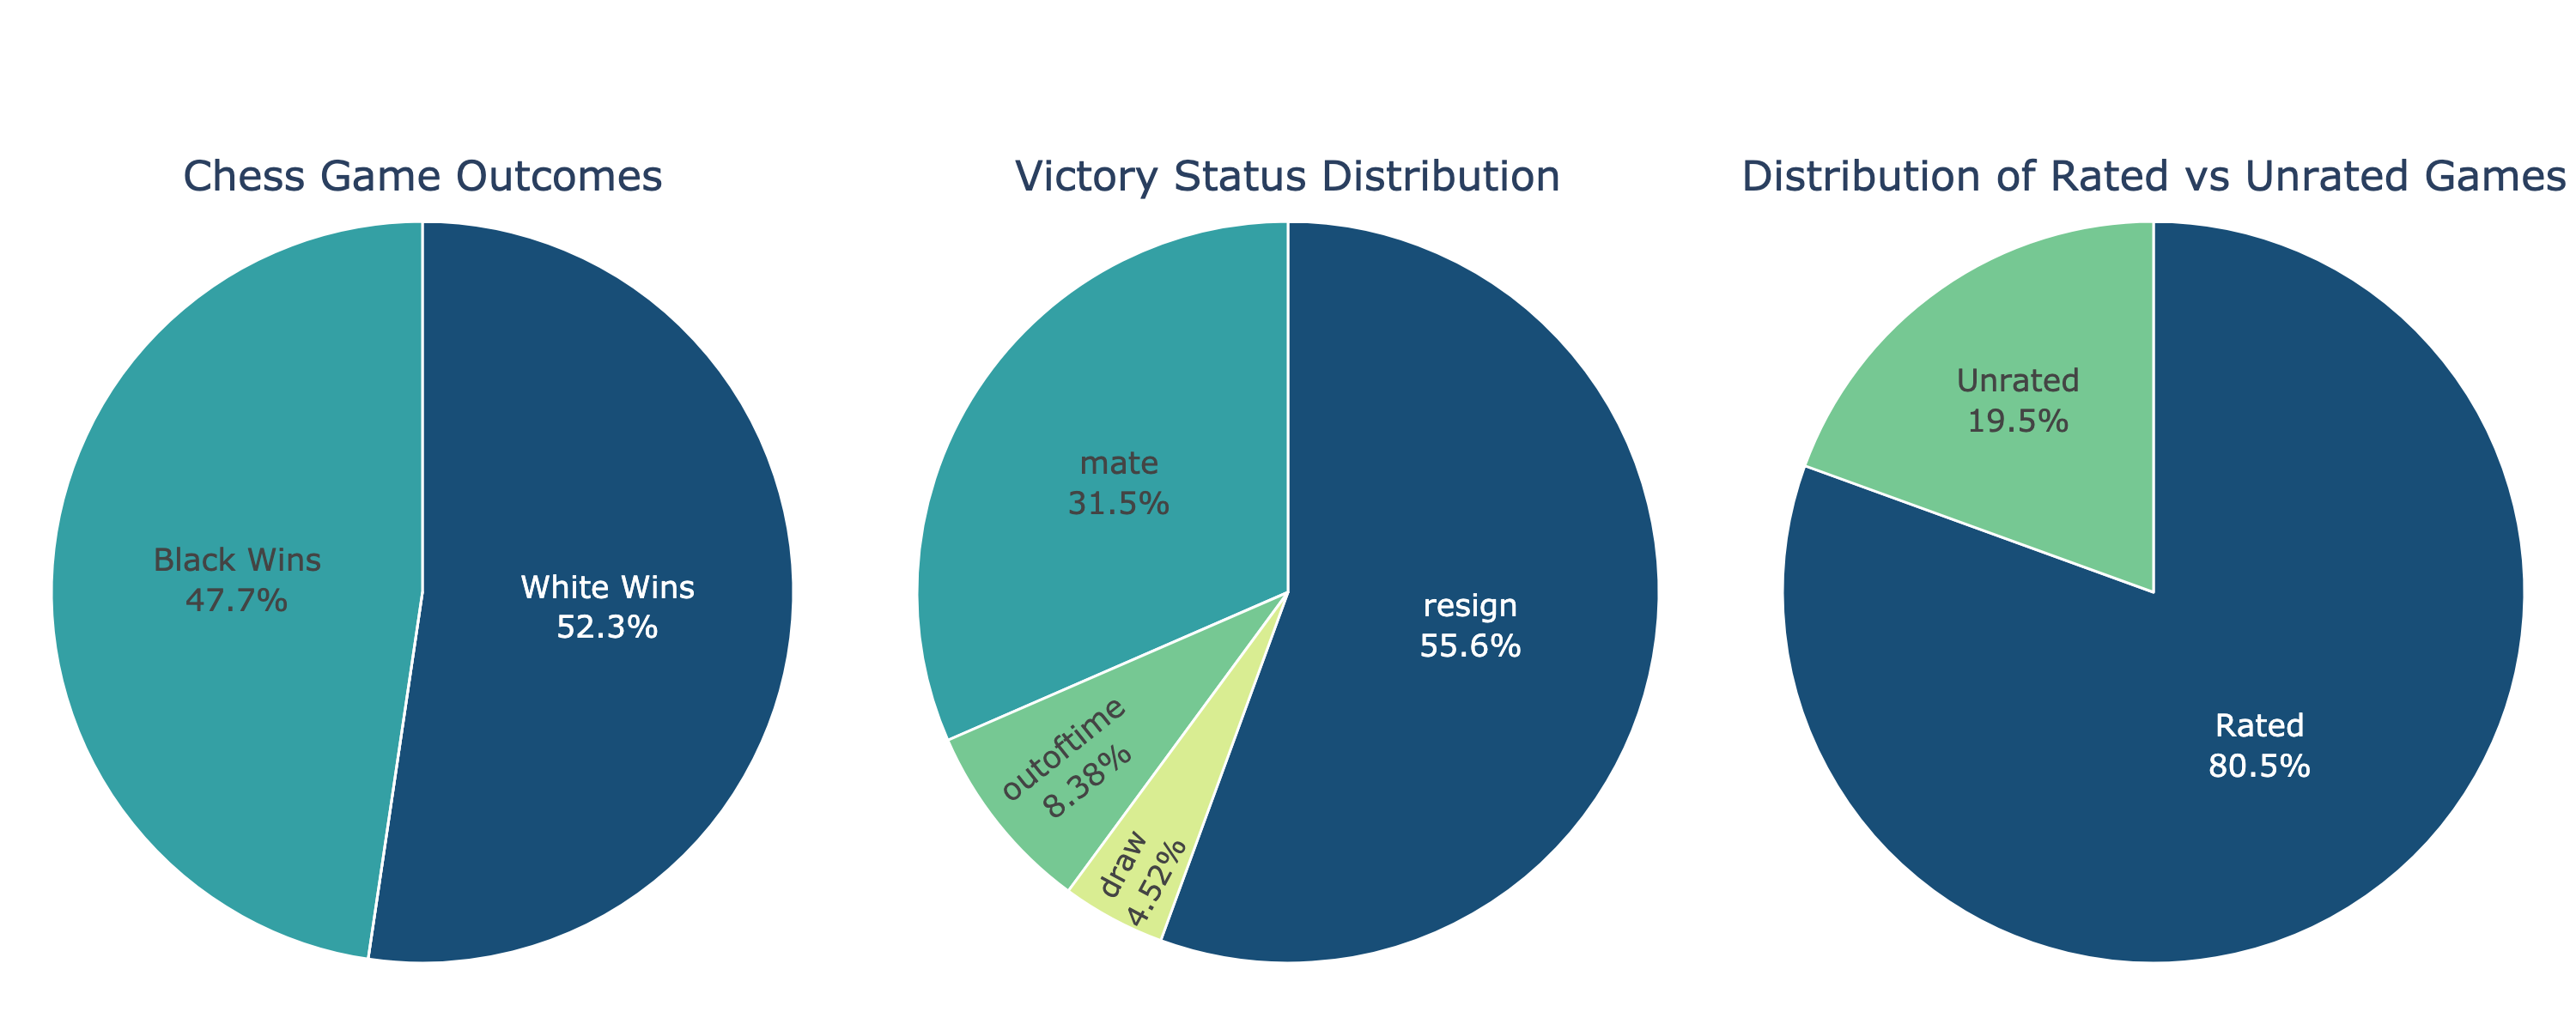

In [476]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create figure with subplots
fig = make_subplots(
   rows=1, cols=3,
   specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]],
   subplot_titles=('Chess Game Outcomes', 'Victory Status Distribution', 'Distribution of Rated vs Unrated Games'),
   horizontal_spacing=0.05  # Reduce space between plots
)

# First pie chart (Game Outcomes)
fig.add_trace(
   go.Pie(
       labels=outcomes_data['Outcome'],
       values=outcomes_data['Games'],
       textposition='inside',
       textinfo='label+percent',
       hovertemplate="<b>%{label}</b><br>" +
                    "Games: %{value:,}<br>" +
                    "Percentage: %{percent:.1f}%<br>" +
                    "<extra></extra>",
       marker=dict(
           colors=['#184E77', '#34A0A4', '#76C893']
       )
   ),
   row=1, col=1
)

# Second pie chart (Victory Status)
fig.add_trace(
   go.Pie(
       labels=victory_data['Status'],
       values=victory_data['Games'],
       textposition='inside',
       textinfo='label+percent',
       hovertemplate="<b>%{label}</b><br>" +
                    "Games: %{value:,}<br>" +
                    "Percentage: %{percent:.1f}%<br>" +
                    "<extra></extra>",
       marker=dict(
           colors=['#184E77', '#34A0A4', '#76C893', '#D9ED92']
       )
   ),
   row=1, col=2
)

# Third pie chart (Rated vs unrated)
fig.add_trace(
   go.Pie(
       labels=game_type_data['Type'],
       values=game_type_data['Games'],
       textposition='inside',
       textinfo='label+percent',
       hovertemplate="<b>%{label}</b><br>" +
                    "Games: %{value:,}<br>" +
                    "Percentage: %{percent:.1f}%<br>" +
                    "<extra></extra>",
       marker=dict(
           colors=['#184E77', '#76C893']
       )
   ),
   row=1, col=3
)

fig.update_layout(
   height=400,  # Reduced from 500
   width=1000,  # Reduced from 1500
   showlegend=False,
   title_font_size=16,  # Reduced from 20
   margin=dict(t=80, b=20, l=20, r=20)  # Reduce margins
)

# traces
for i in range(len(fig.data)):
   fig.data[i].marker.line = dict(color='#FFFFFF', width=1)

fig.show()

And let's make bar graphs for the other variables: the distribution of ratings, of first moves, and of time conditions:

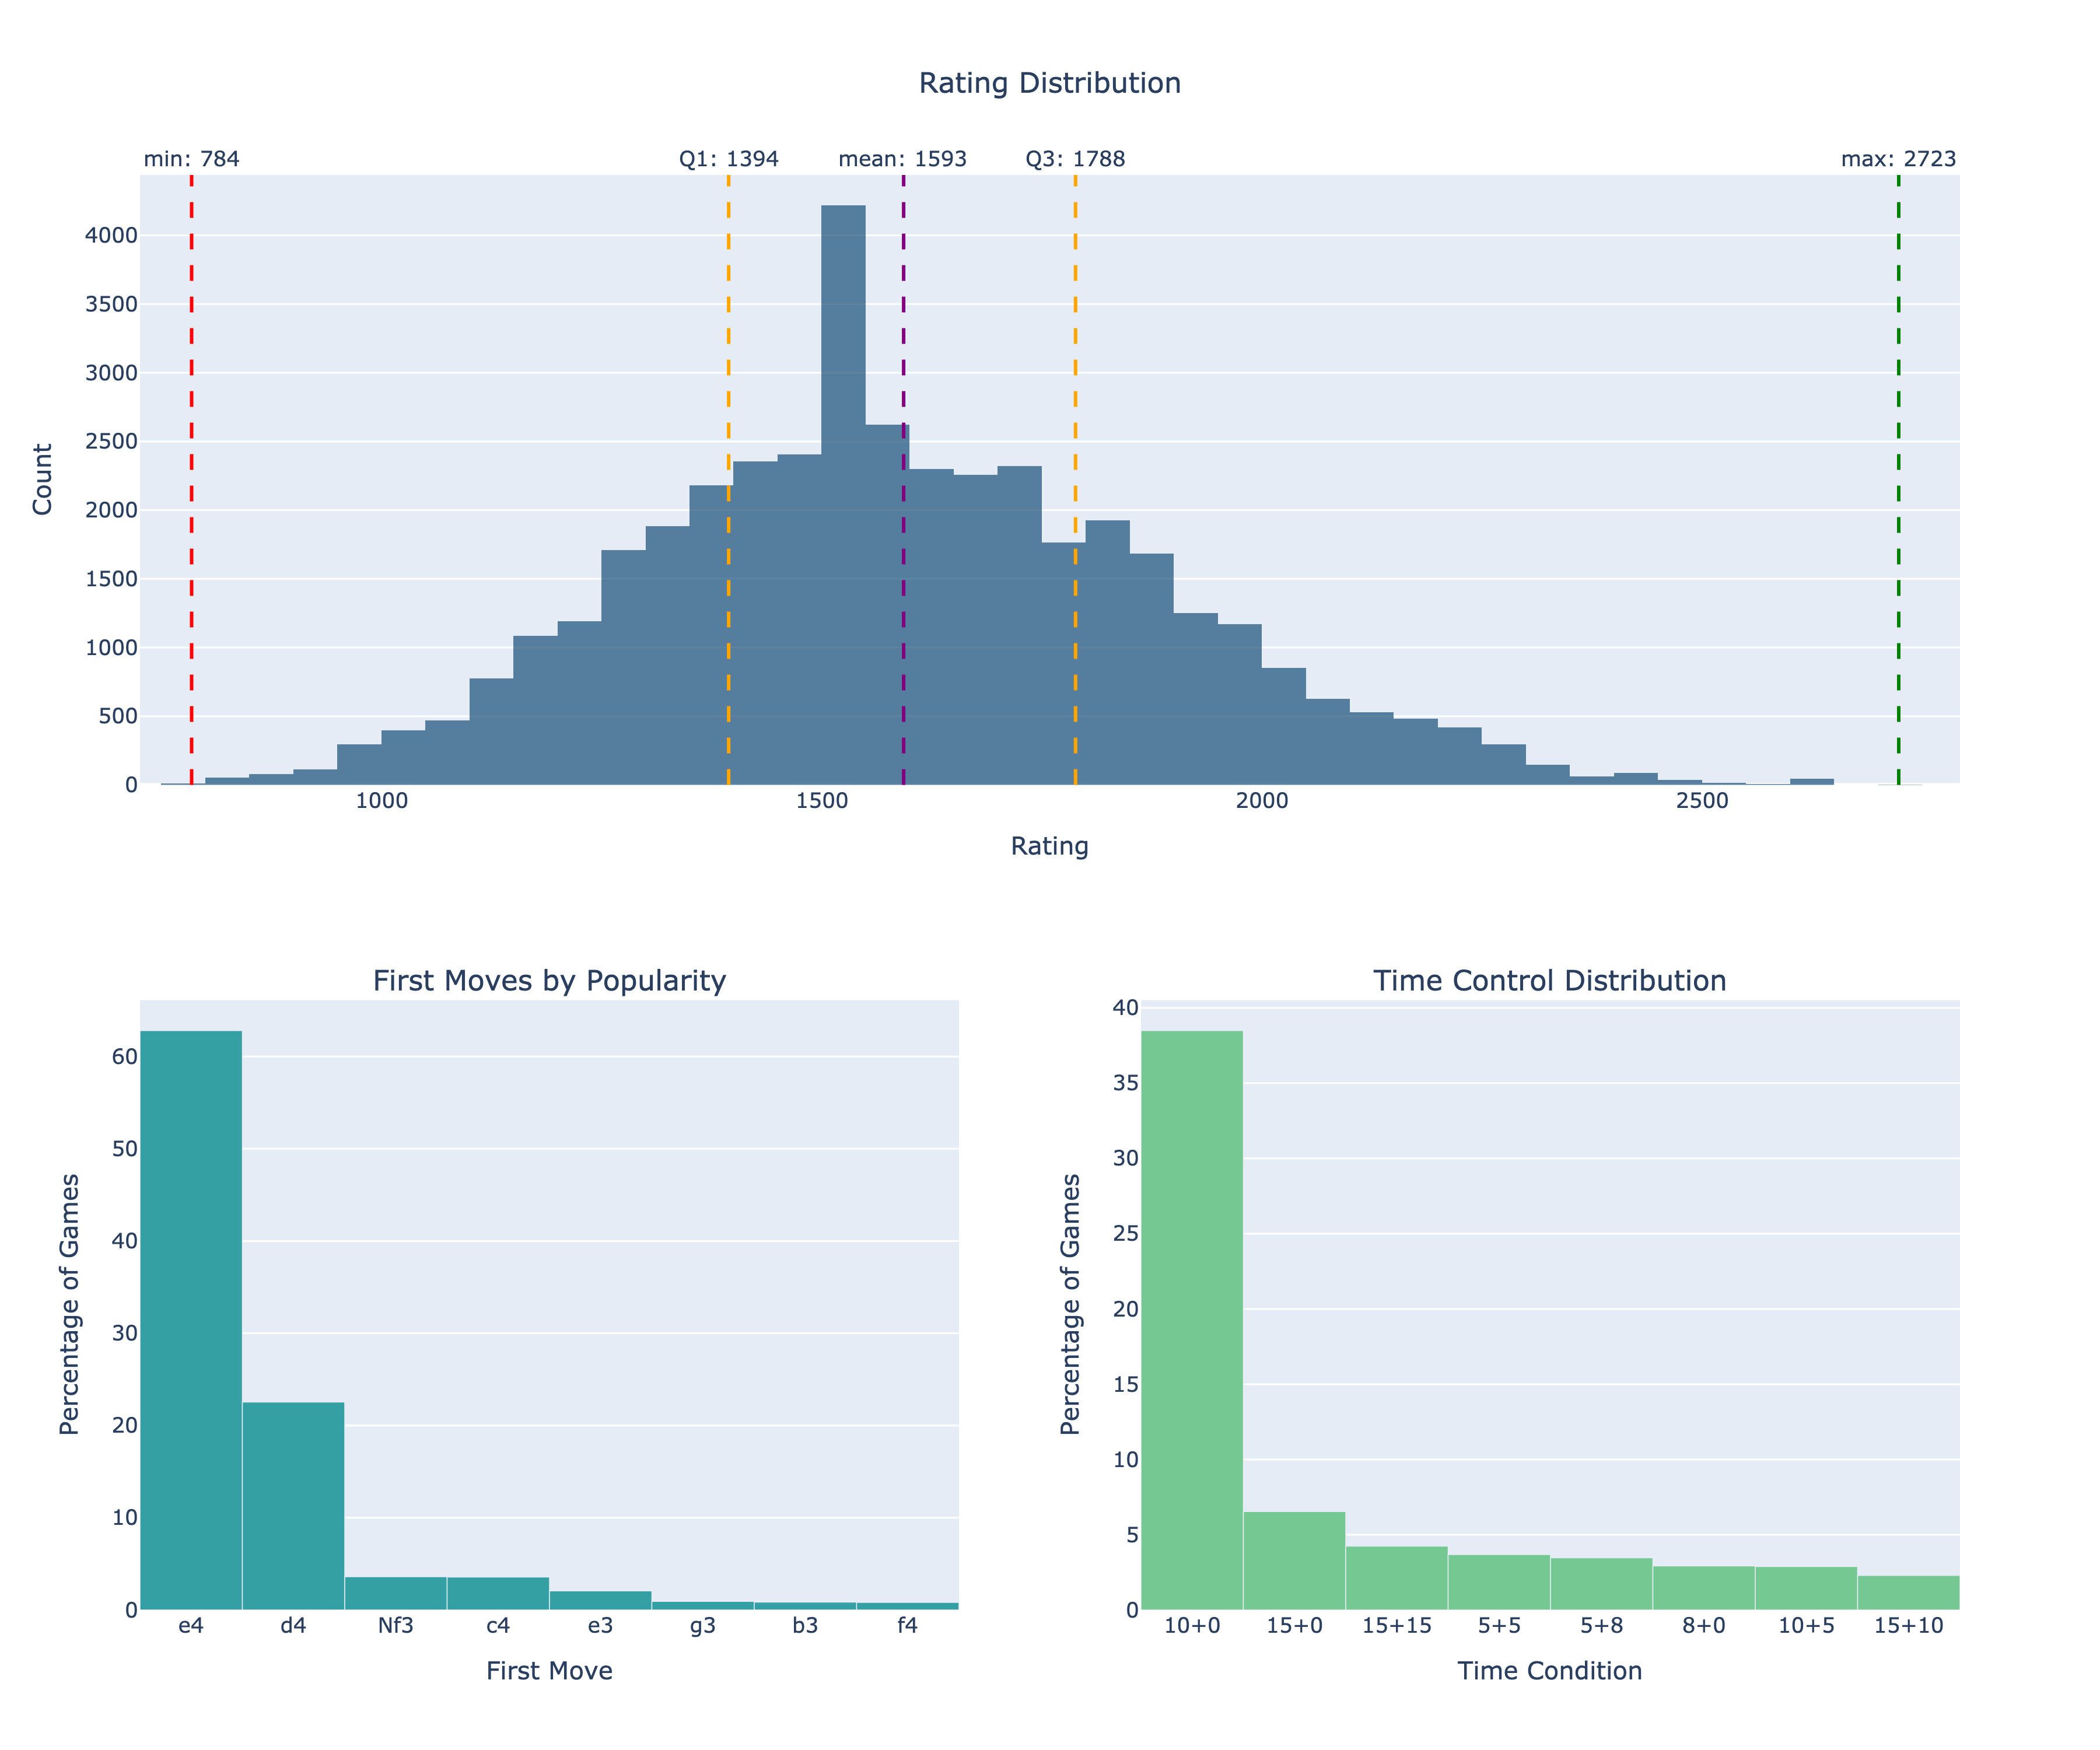

In [477]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

# make a figure with subplots
fig = make_subplots(
   rows=2, cols=2,
   specs=[[{'colspan': 2}, None],
          [{}, {}]],
   vertical_spacing=0.15,
   subplot_titles=('Rating Distribution', 'First Moves by Popularity', 'Time Control Distribution')
)

# 1st plot (ratings Distribution)
fig.add_trace(
   go.Histogram(
       x=all_ratings,
       nbinsx=50,
       name='Rating Distribution',
       hovertemplate='Rating: %{x}<br>Count: %{y}<extra></extra>',
       opacity=0.7,
       marker_color='#184E77'
   ),
   row=1, col=1
)

#  vertical lines for stats
for stat_name, value in stats.items():
   fig.add_vline(
       x=value,
       line_dash="dash",
       line_color=colors[stat_name],
       row=1, col=1,
       annotation_text=f"{stat_name}: {value:.0f}",
       annotation_position="top"
   )

# 2nd plot (First Moves)
fig.add_trace(
   go.Bar(
       x=first_moves.index,
       y=first_moves_percentage,
       marker_color='#34A0A4'
   ),
   row=2, col=1
)

# 3rd plot (Time Controls)
fig.add_trace(
   go.Bar(
       x=time_controls.index,
       y=time_controls_percentage,
       marker_color='#76C893'
   ),
   row=2, col=2
)

#  layout
fig.update_layout(
   height=1000,
   width=1200,
   showlegend=False,
   title_x=0.5,
   title_font_size=16,
)

fig.layout.annotations[0].y += 0.05

fig.update_xaxes(title_text="Rating", row=1, col=1)
fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_yaxes(title_text="Percentage of Games", row=2, col=1)
fig.update_yaxes(title_text="Percentage of Games", row=2, col=2)
fig.update_xaxes(title_text="First Move", row=2, col=1)
fig.update_xaxes(title_text="Time Condition", row=2, col=2)

fig.show()

<h2>Part Two: Tracking Correlations Between Variables</h2>

Let's first answer one of our main objectives: how does player ranking affect the game outcome? 

To do this, we'll create 5 line charts, each one tracking how one of our other main features changes at every level of average player ranking. Player rankings will be split into buckets with roughly an equal number of games in each one.

In [478]:
"""In this cell, we prepare our data to be visualized"""

from plotly.subplots import make_subplots

# first moves calculations
first_moves_of_interest = ['e4', 'd4', 'c4', 'Nf3']
df['first_move'] = df['moves'].str.split().str[0]

# time controls
top_time_controls = df['increment_code'].value_counts().head(5).index.tolist()

# splitting games into bins
bins = 10
df['rating_range'] = pd.qcut(df['white_rating'], q=bins)
results = pd.DataFrame()

for interval in df['rating_range'].unique().categories:
    range_games = df[df['rating_range'] == interval]
    total_games = len(range_games)

    # win %
    white_wins = round((range_games['winner'] == 'white').sum() / total_games * 100, 2)
    black_wins = round((range_games['winner'] == 'black').sum() / total_games * 100, 2)
    draws = round((range_games['winner'] == 'draw').sum() / total_games * 100, 2)

    # rated/unrated game %
    rated_percentage = round((range_games['rated'] == True).sum() / total_games * 100, 2)
    unrated_percentage = round((range_games['rated'] == False).sum() / total_games * 100, 2)

    #  1st move % for top moves
    move_percentages = {
        move: round((range_games['first_move'] == move).sum() / total_games * 100, 2)
        for move in first_moves_of_interest
    }

    # time control % 
    time_control_percentages = {
        tc: round((range_games['increment_code'] == tc).sum() / total_games * 100, 2)
        for tc in top_time_controls
    }

    # win condition %
    victory_percentages = {
        status: round((range_games['victory_status'] == status).sum() / total_games * 100, 2)
        for status in df['victory_status'].unique()
    }

    # data to dict to make visualizations easier
    data_dict = {
        'rating_range': [f"{int(interval.left)}-{int(interval.right)}"],
        'lower_bound': [interval.left],
        'White Wins': [white_wins],
        'Black Wins': [black_wins],
        'Draws': [draws],
        'Rated Games': [rated_percentage],
        'Unrated Games': [unrated_percentage],
        'Number of Games': [total_games]
    }
    data_dict.update(move_percentages)
    data_dict.update(time_control_percentages)
    data_dict.update(victory_percentages)

    # Append the data to  df
    results = pd.concat([results, pd.DataFrame(data_dict)])

# Results by rating range
results = results.sort_values('lower_bound')

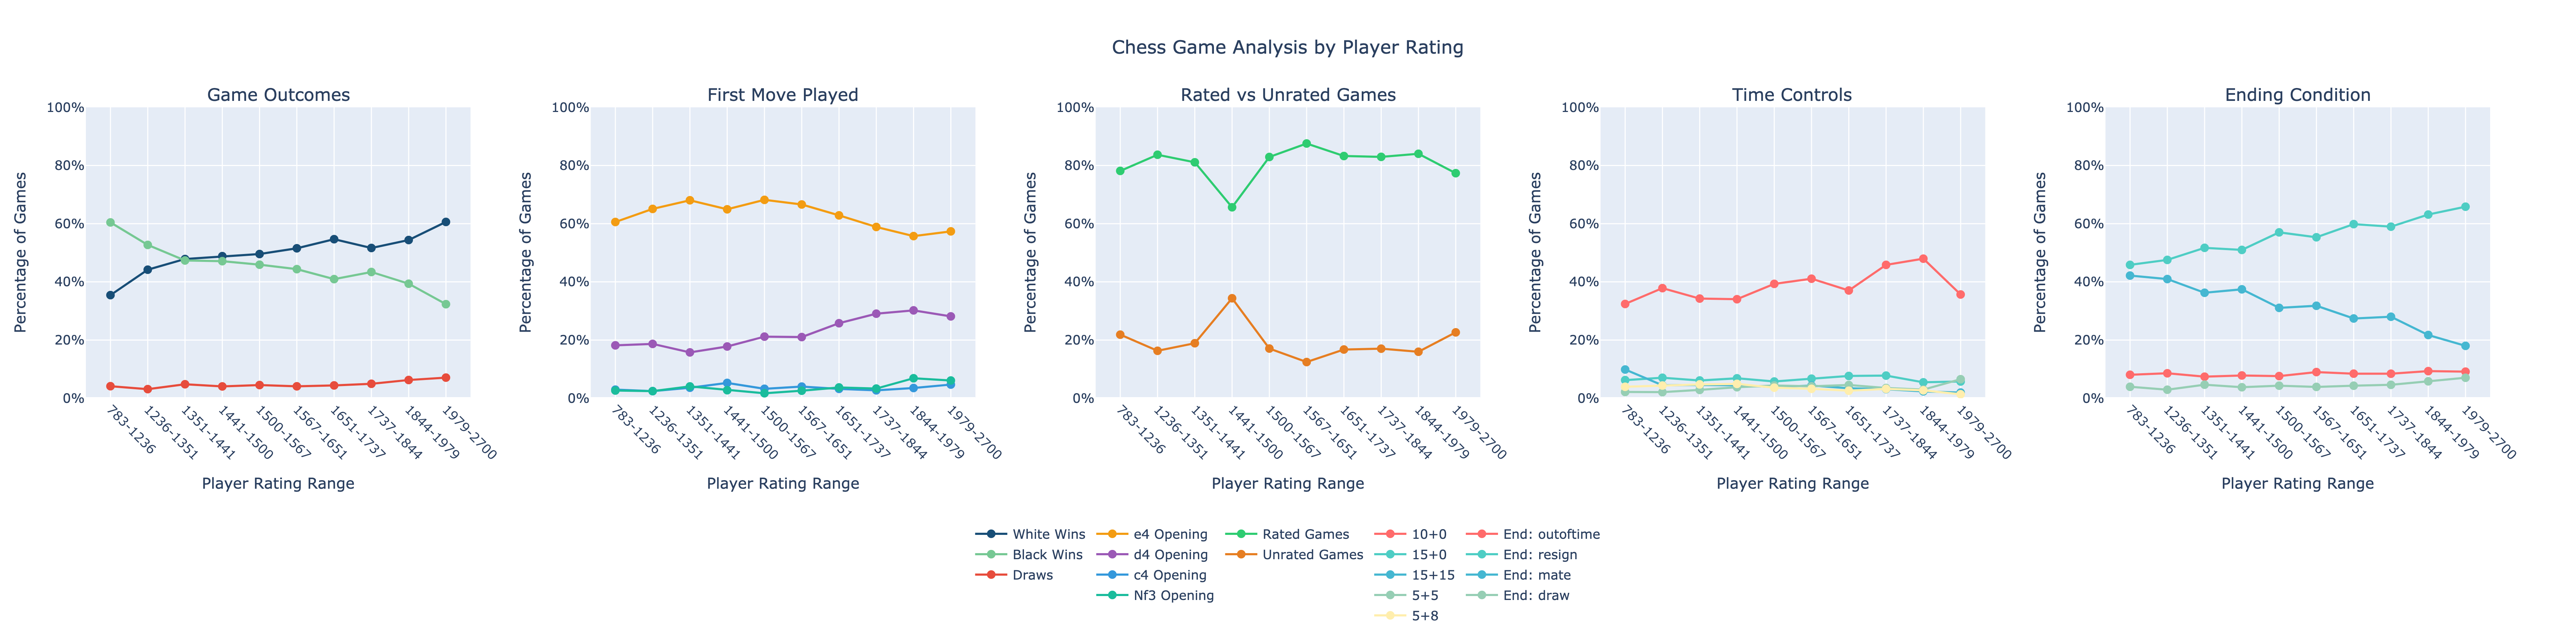


Statistics by Rating Range:
  rating_range  lower_bound  White Wins  Black Wins  Draws  Rated Games  \
0     783-1236        784.0       35.44       60.43   4.13        78.15   
0    1236-1351       1236.0       44.18       52.70   3.12        83.70   
0    1351-1441       1351.0       47.85       47.35   4.80        81.10   
0    1441-1500       1441.0       48.84       47.11   4.05        65.64   
0    1500-1567       1500.0       49.57       45.90   4.52        82.93   
0    1567-1651       1567.0       51.54       44.37   4.09        87.57   
0    1651-1737       1651.2       54.67       40.94   4.40        83.26   
0    1737-1844       1737.0       51.65       43.39   4.96        82.97   
0    1844-1979       1844.0       54.38       39.36   6.26        84.03   
0    1979-2700       1979.0       60.60       32.32   7.08        77.36   

   Unrated Games  Number of Games     e4     d4  ...   Nf3   10+0  15+0  \
0          21.85             2009  60.58  18.17  ...  2.64  32.40  6.2

In [479]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=1, cols=5,
    subplot_titles=('Game Outcomes', 
                    'First Move Played', 
                    'Rated vs Unrated Games',
                    'Time Controls',
                    'Ending Condition'),
    horizontal_spacing=0.05
)

# Colors for all categories
outcome_colors = {'White Wins': '#184E77', 'Black Wins': '#76C893', 'Draws': '#e74c3c'}
move_colors = {'e4': '#f39c12', 'd4': '#9b59b6', 'c4': '#3498db', 'Nf3': '#1abc9c'}
rated_colors = {'Rated Games': '#2ecc71', 'Unrated Games': '#e67e22'}
time_control_colors = dict(zip(top_time_controls, ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEEAD']))
victory_colors = dict(zip(df['victory_status'].unique(), ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']))

# game outcomes (first plot)
for outcome, color in outcome_colors.items():
    fig.add_trace(go.Scatter(
        x=results['rating_range'], 
        y=results[outcome],
        name=outcome, 
        line=dict(color=color, width=2),
        mode='lines+markers', 
        marker=dict(size=8),
        legendgroup='outcomes'
    ), row=1, col=1)

# first moves (second plot)
for move, color in move_colors.items():
    fig.add_trace(go.Scatter(
        x=results['rating_range'], 
        y=results[move],
        name=f'{move} Opening', 
        line=dict(color=color, width=2),
        mode='lines+markers', 
        marker=dict(size=8),
        legendgroup='moves'
    ), row=1, col=2)

# rated status (third plot)
for status, color in rated_colors.items():
    fig.add_trace(go.Scatter(
        x=results['rating_range'], 
        y=results[status],
        name=status, 
        line=dict(color=color, width=2),
        mode='lines+markers', 
        marker=dict(size=8),
        legendgroup='rated'
    ), row=1, col=3)

# time controls (fourth plot)
for tc, color in time_control_colors.items():
    fig.add_trace(go.Scatter(
        x=results['rating_range'], 
        y=results[tc],
        name=f'{tc}', 
        line=dict(color=color, width=2),
        mode='lines+markers', 
        marker=dict(size=8),
        legendgroup='timecontrols'
    ), row=1, col=4)

# win condition (fifth plot)
for status, color in victory_colors.items():
    fig.add_trace(go.Scatter(
        x=results['rating_range'], 
        y=results[status],
        name=f'End: {status}', 
        line=dict(color=color, width=2),
        mode='lines+markers', 
        marker=dict(size=8),
        legendgroup='victory'
    ), row=1, col=5)

#  layout
fig.update_layout(
    height=600,  
    width=2400,
    title_text="Chess Game Analysis by Player Rating",
    title_x=0.5,
    legend=dict(
        orientation="h",  # Horizontal legend
        yanchor="bottom",
        y=-0.8, 
        xanchor="center",
        x=0.5,
        font=dict(size=12),
    ),
    margin=dict(b=200),  # bottom margin for legends
    hovermode='x unified'
)

fig.update_yaxes(title_text="Percentage of Games", ticksuffix="%", range=[0, 100])
fig.update_xaxes(title_text="Player Rating Range", tickangle=45)

fig.show()

# Print detailed statistics
print("\nStatistics by Rating Range:")
print(results.round(2))

Awesome! This provides us with very clear insights:

1. In terms of game outcomes, draws tend to steadily increase as ratings get higher. This is most often attributed to the fact that, at higher-levels, competitive players are less likely to take risks, which leads to more draw-ish scenarios at the end of the game. White wins also increases as ratings increase--white has a slight but significant first move advantage, and higher-level players are able to take advantage of this more and increase their odds of winning.

2. First move percentages stay relatively constant for the most part, though d4 & Nf3 increase marginally (from ~18% to ~28% for d4, and from ~3% to ~6% for Nf3).

3. As the rating increases, more and more games end with resignations (from ~46% to ~66%) rather than checkmates. This suggest that, most likely, higher-level players are able to spot that they are in a losing position more often, and will resign before getting checkmated. 

Let's create a similar chart to see how the rating **differences** impact win percentages. Here, we'll create a new column for the rating difference, and then split the data into 10 bins based on the difference. To do this, we'll use the pd.qcut() function, which is similar to pd.cut() but uses quantiles to determine the bins. 

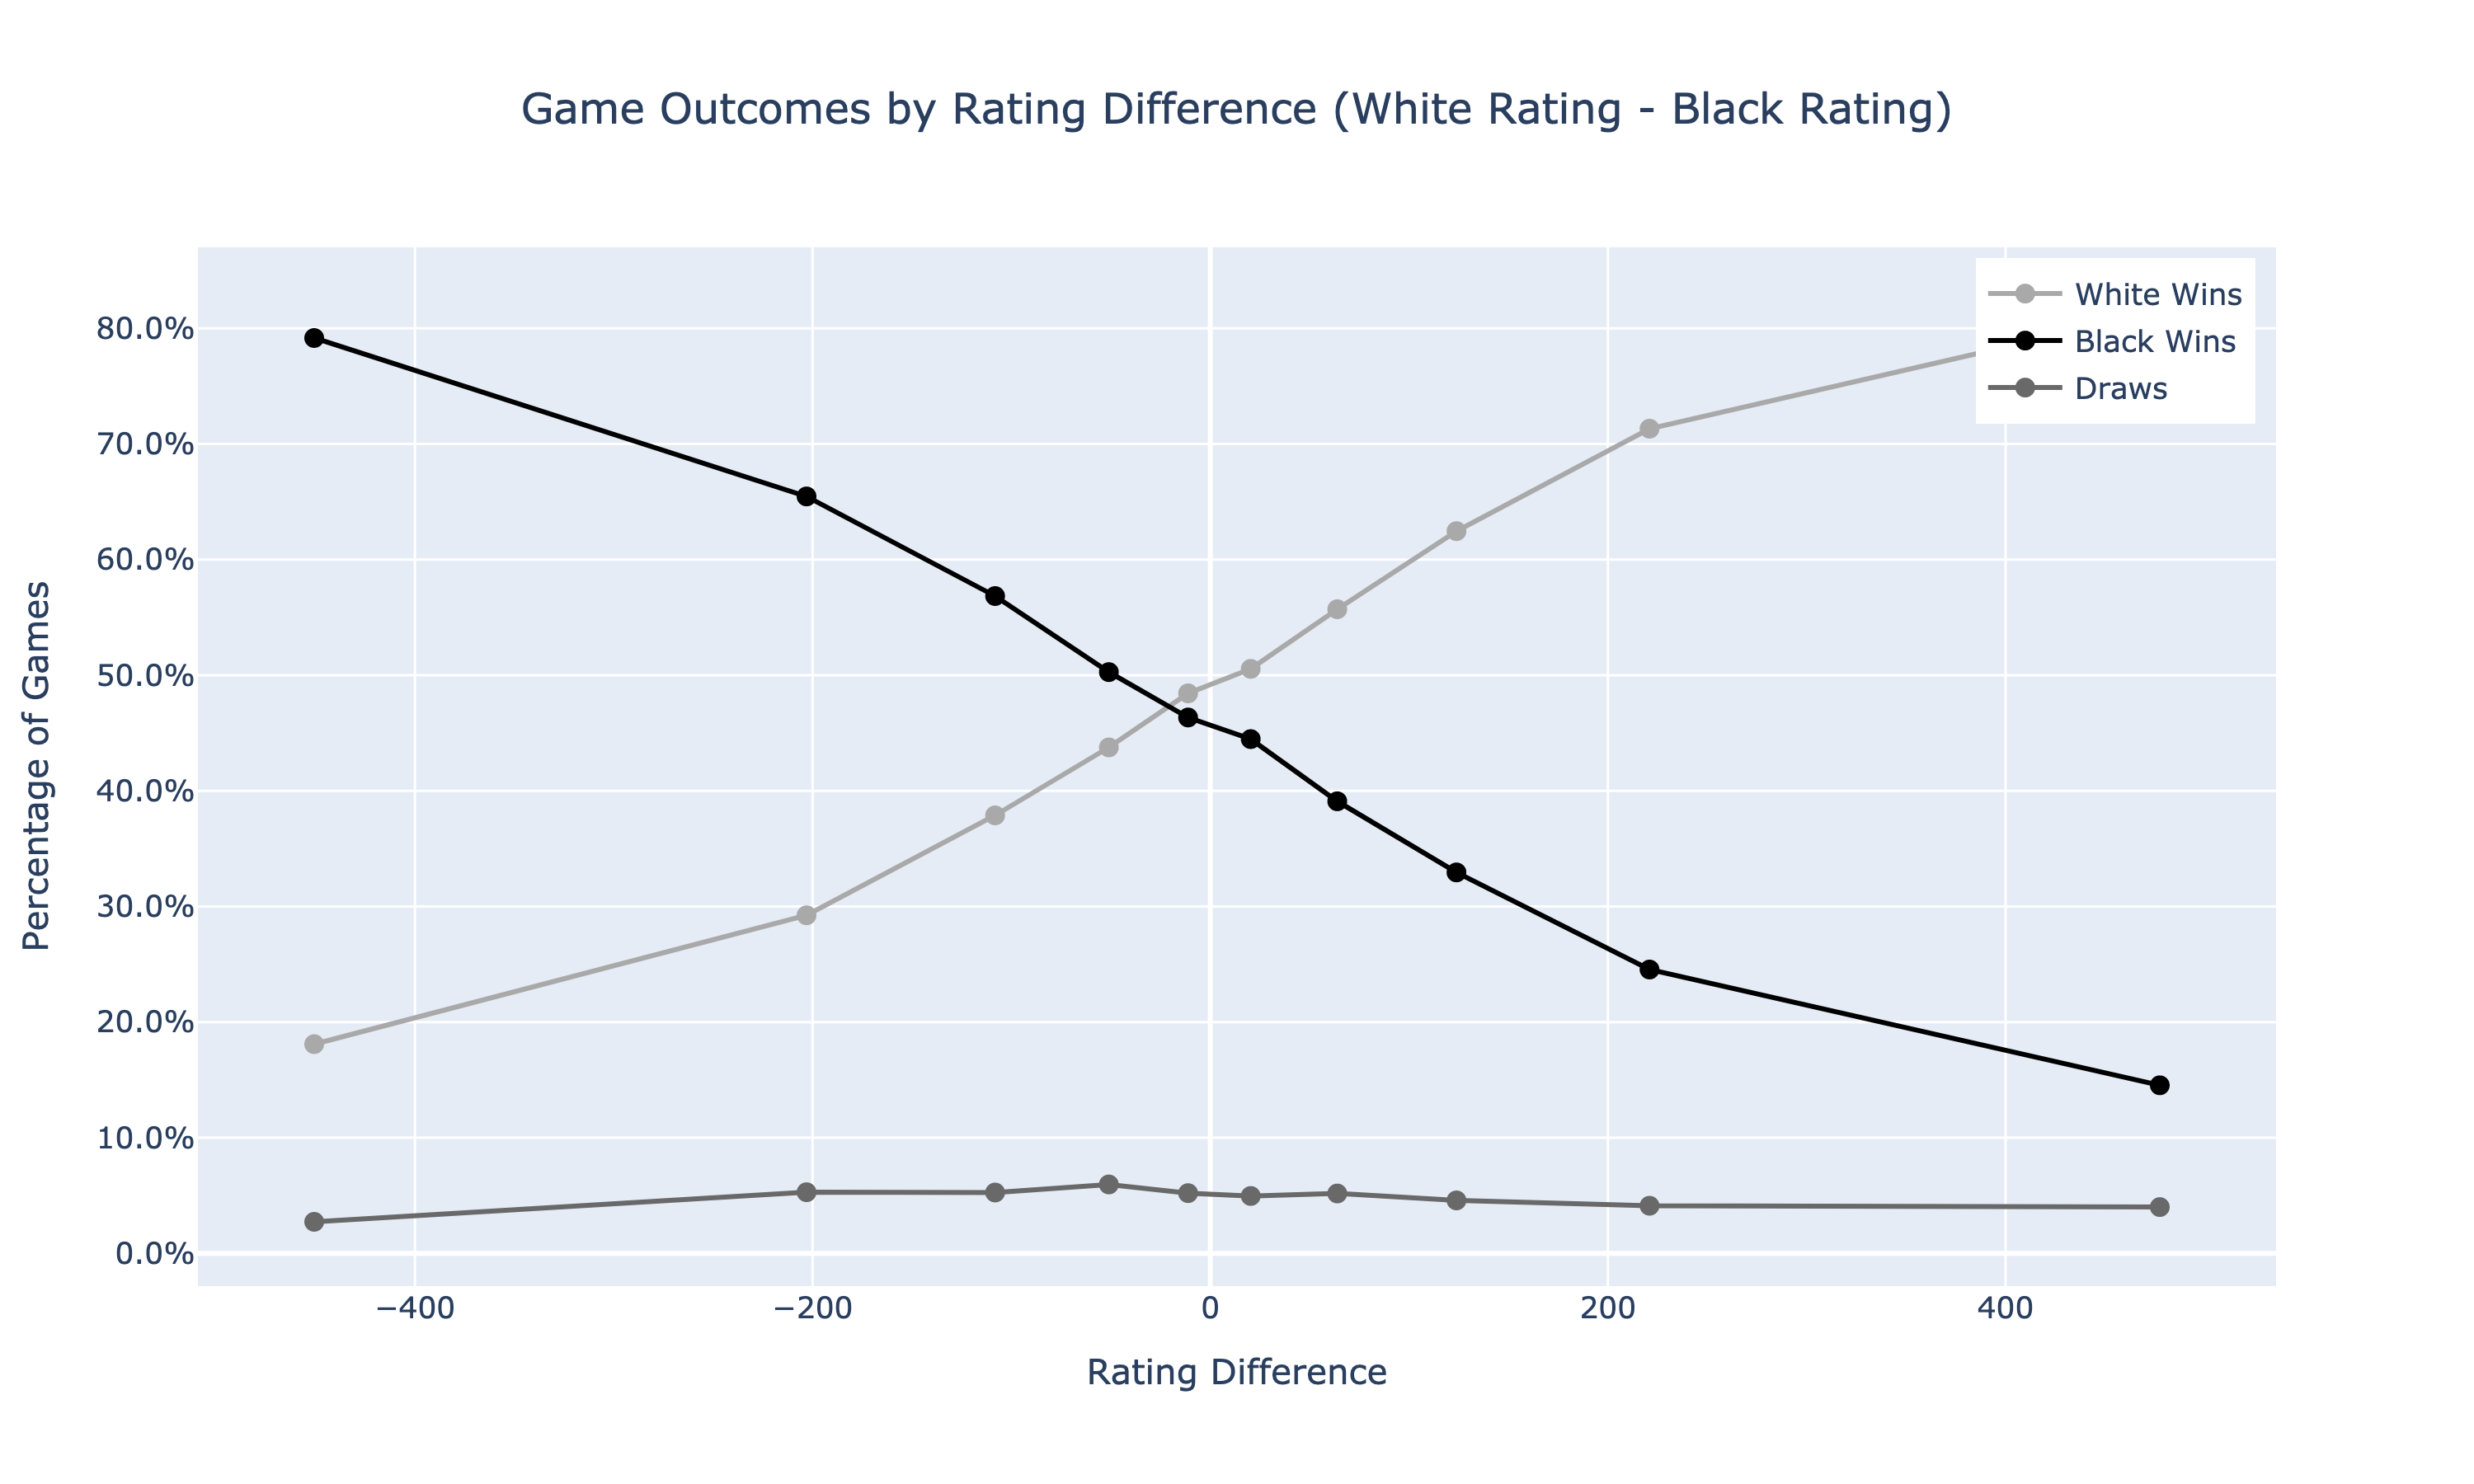

In [480]:
# rating difference == white - black
df['rating_diff'] = df['white_rating'] - df['black_rating']

# bins for rating differences
bins = 10
df['diff_range'] = pd.qcut(df['rating_diff'], q=bins)

# win percentages for each rating difference range
results = pd.DataFrame()
for interval in df['diff_range'].unique().categories:
   range_games = df[df['diff_range'] == interval]
   total_games = len(range_games)
   
   white_wins = (range_games['winner'] == 'white').sum() / total_games * 100
   black_wins = (range_games['winner'] == 'black').sum() / total_games * 100
   draws = (range_games['winner'] == 'draw').sum() / total_games * 100
   
   results = pd.concat([results, pd.DataFrame({
       'diff_range': [f"{int(interval.left)}-{int(interval.right)}"],
       'lower_bound': [interval.left],
       'White Wins': [white_wins],
       'Black Wins': [black_wins],
       'Draws': [draws],
       'Number of Games': [total_games],
       'Avg Difference': [range_games['rating_diff'].mean()]
   })])

results = results.sort_values('lower_bound')


fig = go.Figure()
fig.add_trace(go.Scatter(
   x=results['Avg Difference'],
   y=results['White Wins'],
   name='White Wins',
   mode='lines+markers',
   line=dict(color='#A9A9A9', width=2),
   marker=dict(size=8)
))

fig.add_trace(go.Scatter(
   x=results['Avg Difference'],
   y=results['Black Wins'],
   name='Black Wins',
   mode='lines+markers',
   line=dict(color='black', width=2),
   marker=dict(size=8)
))

fig.add_trace(go.Scatter(
   x=results['Avg Difference'],
   y=results['Draws'],
   name='Draws',
   mode='lines+markers',
   line=dict(color='#696969', width=2),
   marker=dict(size=8)
))


fig.update_layout(
   title='Game Outcomes by Rating Difference (White Rating - Black Rating)',
   xaxis_title='Rating Difference',
   yaxis_title='Percentage of Games',
   width=1000,
   height=600,
   title_x=0.5,
   legend=dict(
       yanchor="top",
       y=0.99,
       xanchor="right",
       x=0.99
   ),
   yaxis=dict(
       tickformat='.1f',
       ticksuffix='%'
   ),
   hovermode='x unified'
)

fig.show()

A very clear trend here: as the difference increases, the side with a higher rank it more likely to win. This suggests that Lichess's player ranking does a pretty accurate job at measuring the player skill levels: at each 100 point increase in rating difference, a player is about 5-10% more likely to win that game—-though the difference does appear to plateau moderately at more extreme differences. Draws also appear to slightly, though consistently, increase as the difference between the two players gets smaller. 

Finally, let's use a Violin chart & a Box plot to visualize two more distributions related to number of moves: 1. how game lengths vary along time controls, and 2. how end conditions vary along game lengths.

To do this, we'll first create a new column for the number of moves, which we can do by counting the number of spaces in the moves column + 1. Then, we'll create a violin plot to compare game lengths across different victory types, and a box plot to compare game lengths across different time controls. 

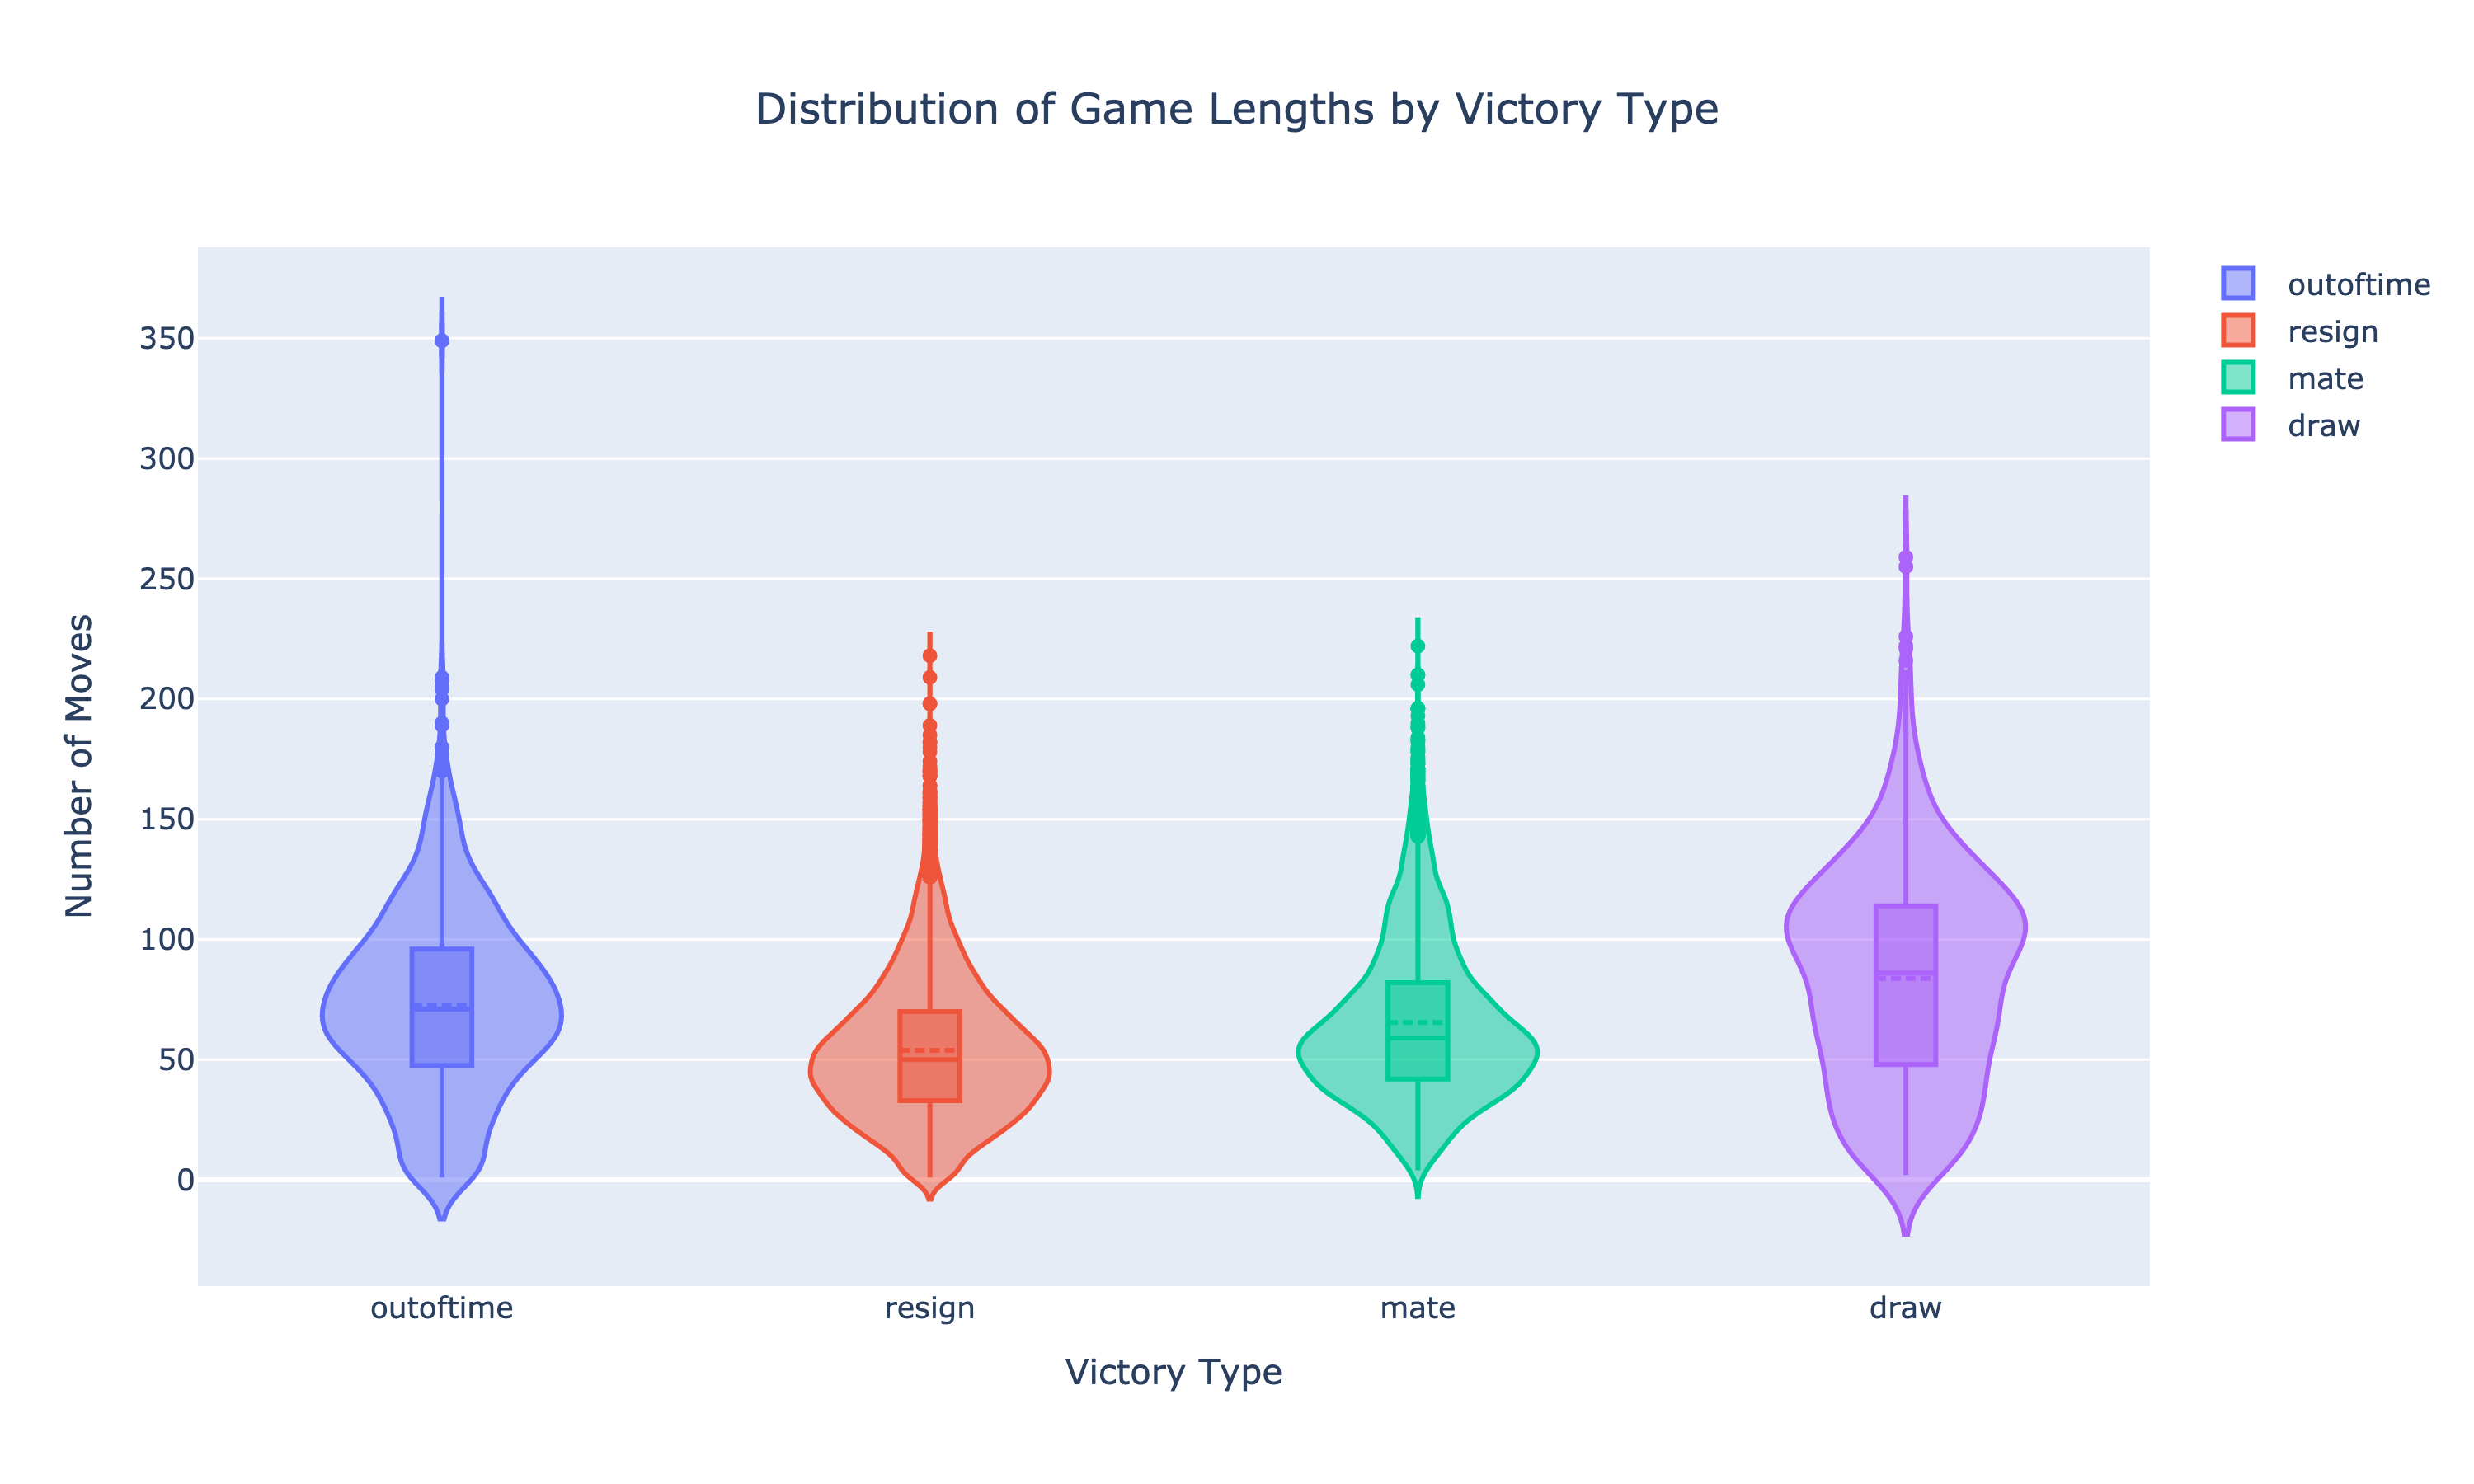

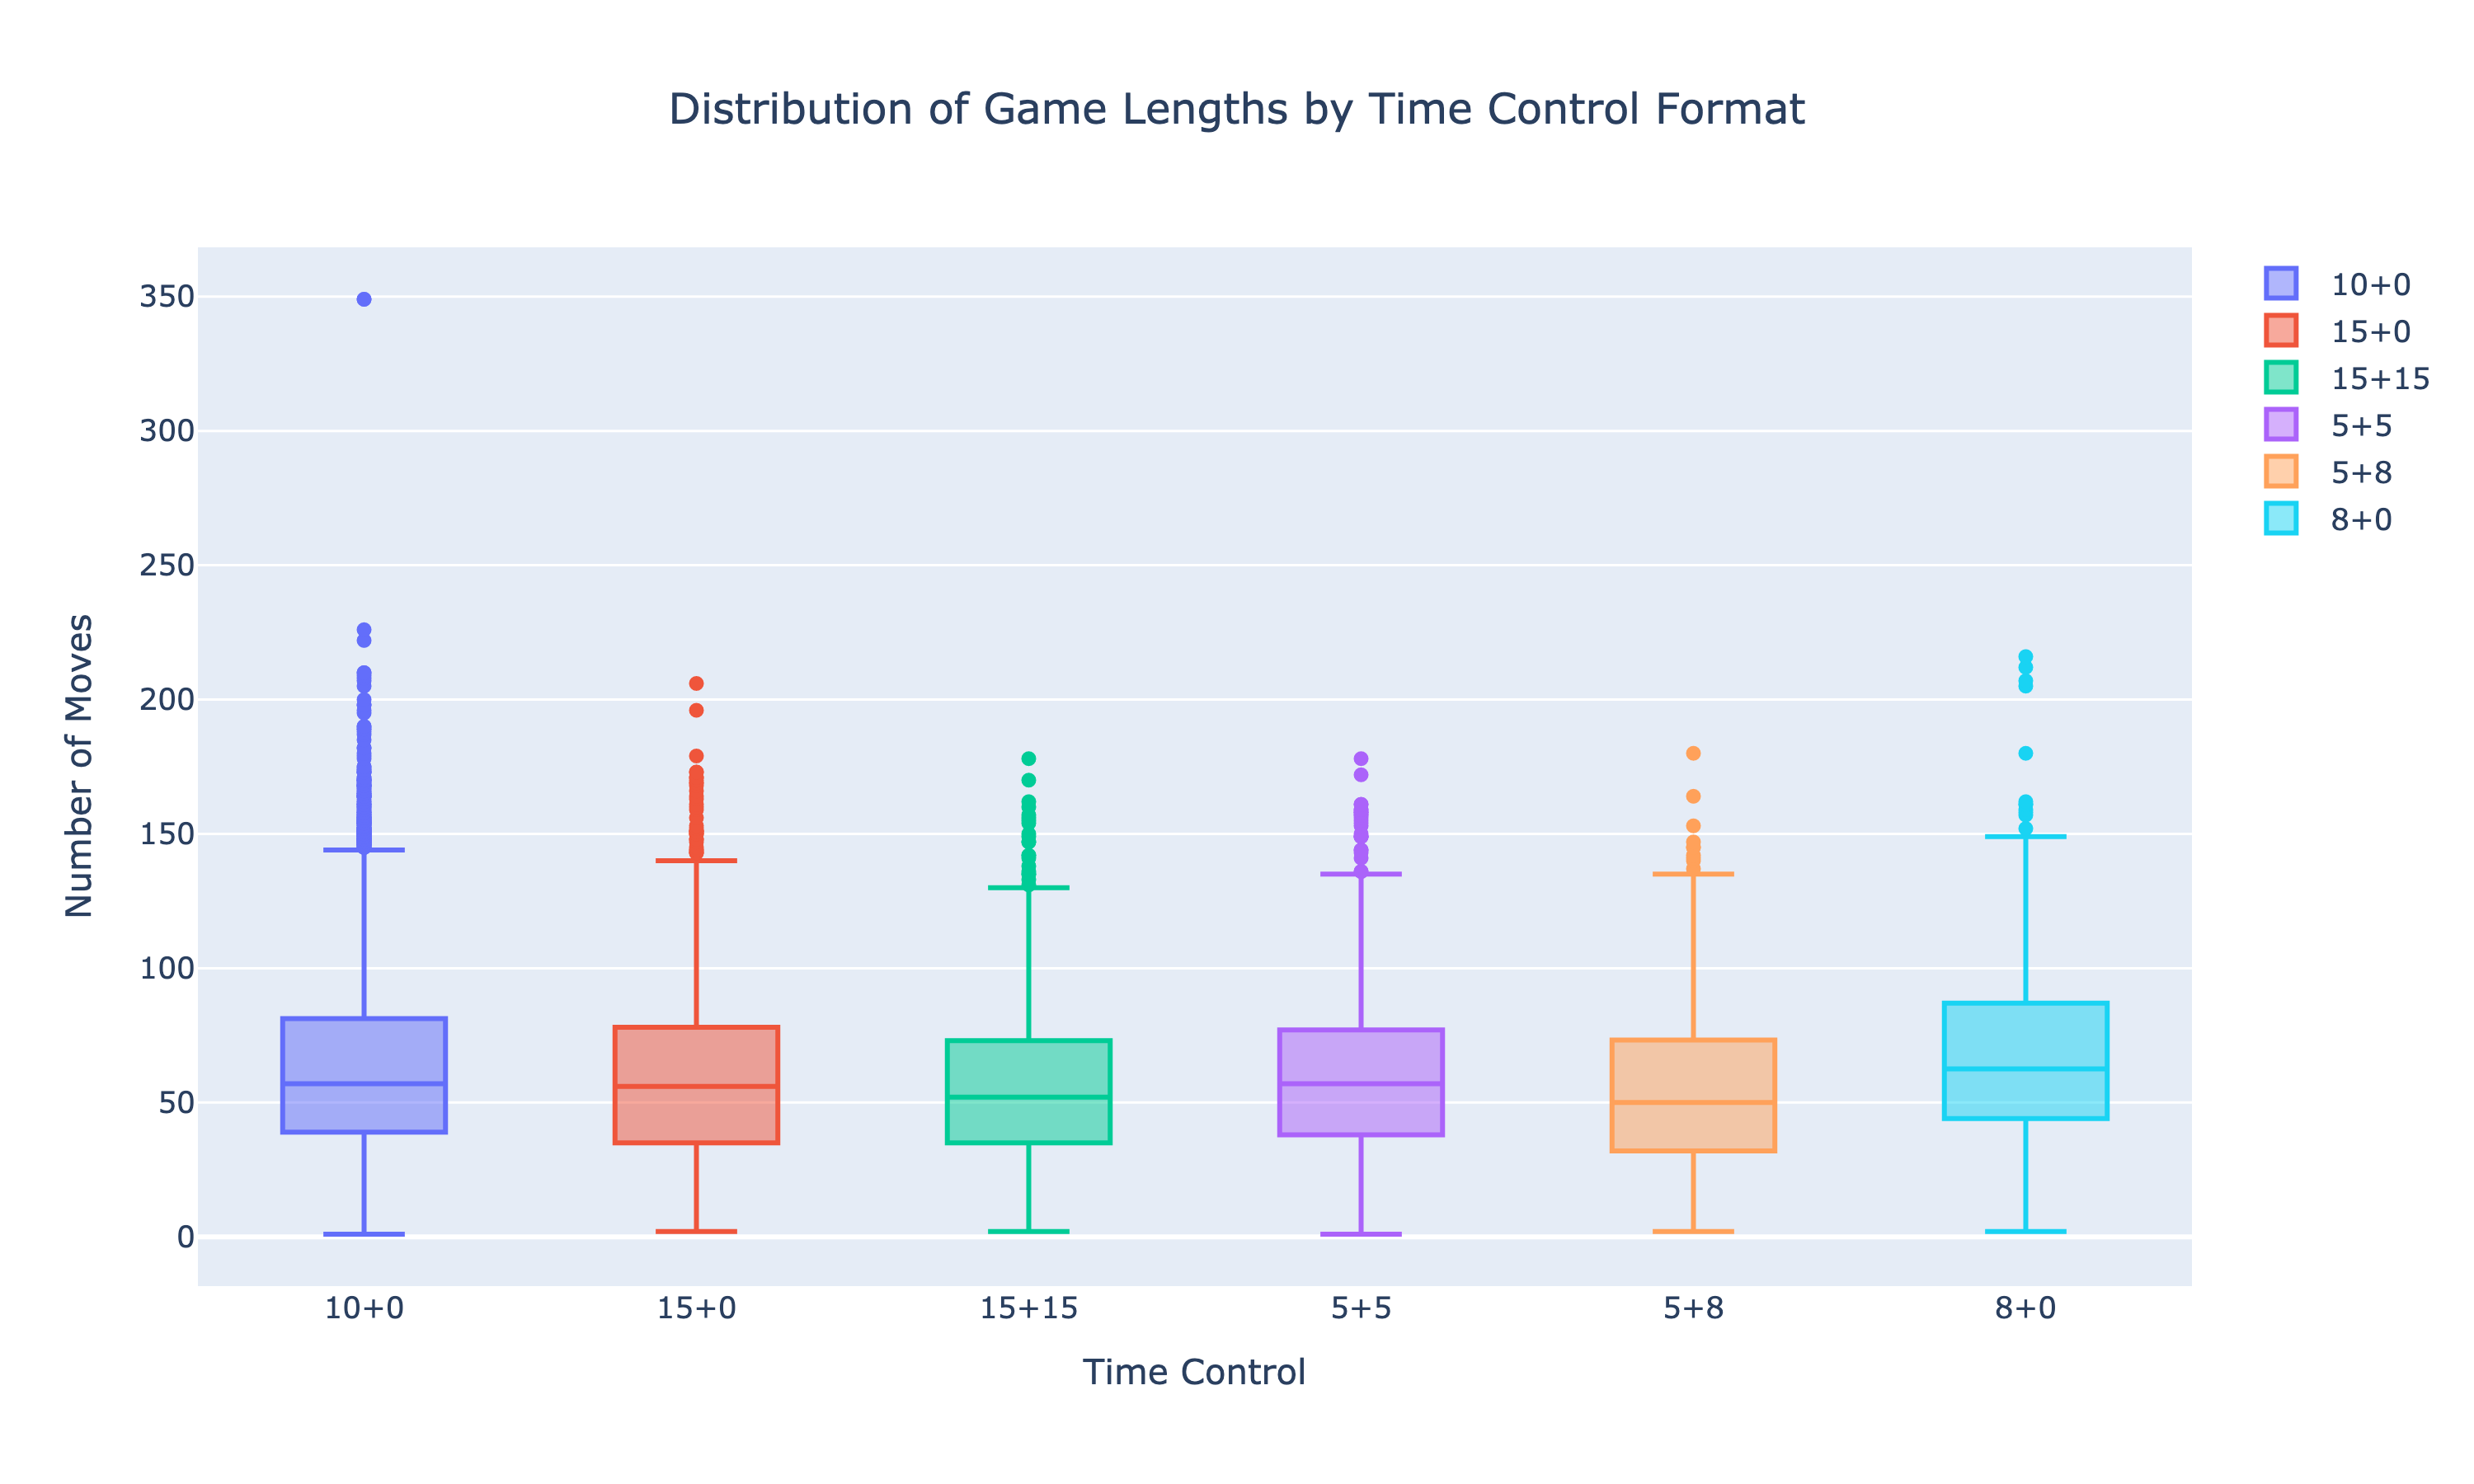

In [481]:
# Calculate number of moves from the 'moves' column by counting spaces + 1
df['num_moves'] = df['moves'].str.count(' ') + 1

# Create violin plot comparing game lengths across different victory types
fig = go.Figure()

for victory_type in df['victory_status'].unique():
    moves = df[df['victory_status'] == victory_type]['num_moves']
    
    fig.add_trace(go.Violin(
        x=[victory_type] * len(moves),
        y=moves,
        name=victory_type,
        box_visible=True,
        meanline_visible=True
    ))

fig.update_layout(
    title='Distribution of Game Lengths by Victory Type',
    xaxis_title='Victory Type',
    yaxis_title='Number of Moves',
    width=1000,
    height=600,
    title_x=0.5
)

fig.show()

fig = go.Figure()

for time_control in df['increment_code'].value_counts().head(6).index:
    moves = df[df['increment_code'] == time_control]['num_moves']
    
    fig.add_trace(go.Box(
        y=moves,
        name=time_control,
        boxpoints='outliers'
    ))

fig.update_layout(
    title='Distribution of Game Lengths by Time Control Format',
    xaxis_title='Time Control',
    yaxis_title='Number of Moves',
    width=1000,
    height=600,
    title_x=0.5
)

fig.show()

**Graph 1** gives some interesting insights: outoftime has much more extreme long games, though draws are, on average, the longest. One possible explanation for this is games where a player runs-out-of-time involves both players making a rapid number of moves without thinking, often missing mate opportunites and moving kings around so they don't run out of time. This would account for the most extreme cases, but in most cases, games where the time-control is a large factor lead to a shorter number of total moves as compared to games with draws, which often go to the endgame and are consistently longer. Resignations and checkmates are, as to be expected, shorter on average than draws and outoftimes; more of these types of endings do not make it to the endgame, which makes them much shorter on average. 

**Graph 2** gives us some more interesting insight, and perhaps explains why outoftime victories have the highest maximums: as we see, the 10+0 time control has the largest number of total moves. This may surpise some people: wouldn't games with stricter time controls end sooner? Well, actually, when both player's have enough time to think, they are less likely to play in rapid, wild, and unpredictable ways that don't bring the game closer to its conclusion. The high extremes of number of moves for shorter time conditions is most likely explained by this, though there are likely other possibilites to consider. 

<h2>Part Three: Incorporating Additional Datasets</h2>

Here, we'll start incorporating our other two datasets: one of grandmaster chess games, and one of chess games played by AI. Let's first load in our files: 

In [482]:
import pandas as pd

# grandmaster dataset
df2 = pd.read_csv('games2.csv')

# ai games dataset
df3 = pd.read_csv('games3.csv')

print(df2.head(5))
print(df3.head(5))

  player  color                     opponent  player_Elo  opponent_Elo result  \
0    Tal  Black           Feibert Fred (GER)         NaN        2285.0    Win   
1    Tal  Black  Westerinen Heikki M J (FIN)         NaN        2410.0    Win   
2    Tal  Black            Larsen Bent (DEN)         NaN        2565.0    Win   
3    Tal  White  Azmaiparashvili Zurab (GEO)         NaN        2470.0   Draw   
4    Tal  White            Wedberg Tom (SWE)         NaN        2480.0    Win   

                 event                            site        date  \
0            It (open)              Leningrad (Russia)  1991.??.??   
1                   It                 Moscow (Russia)  1982.??.??   
2          It (cat.14)  Bugojno (Bosnia & Herzegovina)  1984.??.??   
3  Memorial V.Goglidze               Tbilisi (Georgia)  1986.??.??   
4            It (open)                  New York (USA)  1990.??.??   

                                               lines  moves  \
0  1. d4 Nf6 2. Nf3 c5 3. c3 

Then, let's filter down dataset 2 so it contains the same columns as dataset 1, with our data represented in the same format. Since some player_elo and opponent_elo values are missing, we'll clear them out; we'll also use the combination of if the player is winning and the player's color to determine which color is the victor (so it matches the formatting of the first dataset). Finally, we'll have to parse out the numbering in the moves to make it match the first dataset, which does not contain number before each move. 

In [483]:
import pandas as pd

#  dataset
df2 = pd.read_csv('games2.csv')

def transform_games2_dataset(df2):
    # remove rows with missing or zero ratings
    df_transformed = df2[
        (df2['player_Elo'].notna()) & 
        (df2['opponent_Elo'].notna()) & 
        (df2['player_Elo'] != 0) & 
        (df2['opponent_Elo'] != 0)
    ].copy()
    
    # determine winner
    def determine_winner(row):
        if row['result'] == 'Draw':
            return 'draw'
        elif row['result'] == 'Win':
            return row['color'].lower()
        return None
    
    # rating to assign
    def assign_ratings(row):
        if row['color'] == 'White':
            return pd.Series({
                'white_rating': row['player_Elo'],
                'black_rating': row['opponent_Elo']
            })
        else:
            return pd.Series({
                'white_rating': row['opponent_Elo'],
                'black_rating': row['player_Elo']
            })
    
    # clean up our chess moves
    def clean_chess_moves(moves_str):
        if pd.isna(moves_str):
            return ""
        parts = moves_str.split()
        cleaned_moves = [part for part in parts if '.' not in part]
        return ' '.join(cleaned_moves)
    
    # Apply changes that we made
    df_transformed['winner'] = df_transformed.apply(determine_winner, axis=1)
    ratings = df_transformed.apply(assign_ratings, axis=1)
    df_transformed['white_rating'] = ratings['white_rating'].astype(int)
    df_transformed['black_rating'] = ratings['black_rating'].astype(int)
    df_transformed['moves'] = df_transformed['lines'].fillna("").apply(clean_chess_moves)
    
    return df_transformed[['winner', 'white_rating', 'black_rating', 'moves']]

df2 = transform_games2_dataset(df2)

# needs to be lowercase to match the other datasets
df3['winner'] = df3['winner'].str.lower()

print("Lichess Games")
print(df.head(2))
print()
print("Grandmaster Games")
print(df2.head(2))
print("AI Games")
print(df3.head(50))


Lichess Games
   rated victory_status winner  white_rating  black_rating  \
0  False      outoftime  white          1500          1191   
1   True         resign  black          1322          1261   

                                               moves increment_code  \
0  d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...           15+2   
1  d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...           5+10   

  first_move      rating_range  rating_diff       diff_range  num_moves  
0         d4  (1441.0, 1500.0]          309  (293.0, 1499.0]         13  
1         d4  (1236.0, 1351.0]           61     (39.0, 89.0]         16  

Grandmaster Games
   winner  white_rating  black_rating  \
28   draw          2530          2620   
54   draw          2535          2600   

                                                moves  
28  e4 c5 Nf3 d6 d4 cxd4 Qxd4 Nc6 Bb5 Bd7 Bxc6 Bxc...  
54  d4 Nf6 c4 e6 g3 c5 d5 exd5 cxd5 d6 Nc3 g6 Bg2 ...  
AI Games
    game_number winner                     

Awesome! Now, all three of our datasets share the following datapoints:

1. Wins by color

2. Moves

And, in addition, datasets 1 and 2 both have ratings for white and black. 

Let's start by comparing the average player ratings in the first two datasets, and then show the average number of moves & most likely game outcomes across all 3:

To do this, we'll create a bar chart for the average ratings, a bar chart for the average number of moves, and a stacked bar chart for the win percentages. 

In [484]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

ratings_df1 = pd.DataFrame({
    'Dataset': ['Lichess Games'] * 2,
    'Color': ['White', 'Black'],
    'Rating': [round(df['white_rating'].mean(), 2), round(df['black_rating'].mean(), 2)]
})

ratings_df2 = pd.DataFrame({
    'Dataset': ['Grandmaster Games'] * 2,
    'Color': ['White', 'Black'],
    'Rating': [round(df2['white_rating'].mean(), 2), round(df2['black_rating'].mean(), 2)]
})

ratings_combined = pd.concat([ratings_df1, ratings_df2])

# Calculate average moves length for all three datasets with rounding
df['moves_length'] = df['moves'].str.count(' ') + 1
df2['moves_length'] = df2['moves'].str.count(' ') + 1
df3['moves_length'] = df3['moves'].str.count(' ') + 1

moves_df = pd.DataFrame({
    'Dataset': ['Lichess Games', 'Grandmaster Games', 'AI Games'],
    'Average Moves': [round(df['moves_length'].mean(), 2), round(df2['moves_length'].mean(), 2), round(df3['moves_length'].mean(), 2)]
})

# Calculate win percentages for all three datasets with rounding
def get_win_percentages(df):
    total = len(df)
    white_wins = round(len(df[df['winner'] == 'white']) / total * 100, 2)
    black_wins = round(len(df[df['winner'] == 'black']) / total * 100, 2)
    draws = round(len(df[df['winner'] == 'draw']) / total * 100, 2)
    return white_wins, black_wins, draws

wins_df1 = get_win_percentages(df)
wins_df2 = get_win_percentages(df2)
wins_df3 = get_win_percentages(df3)

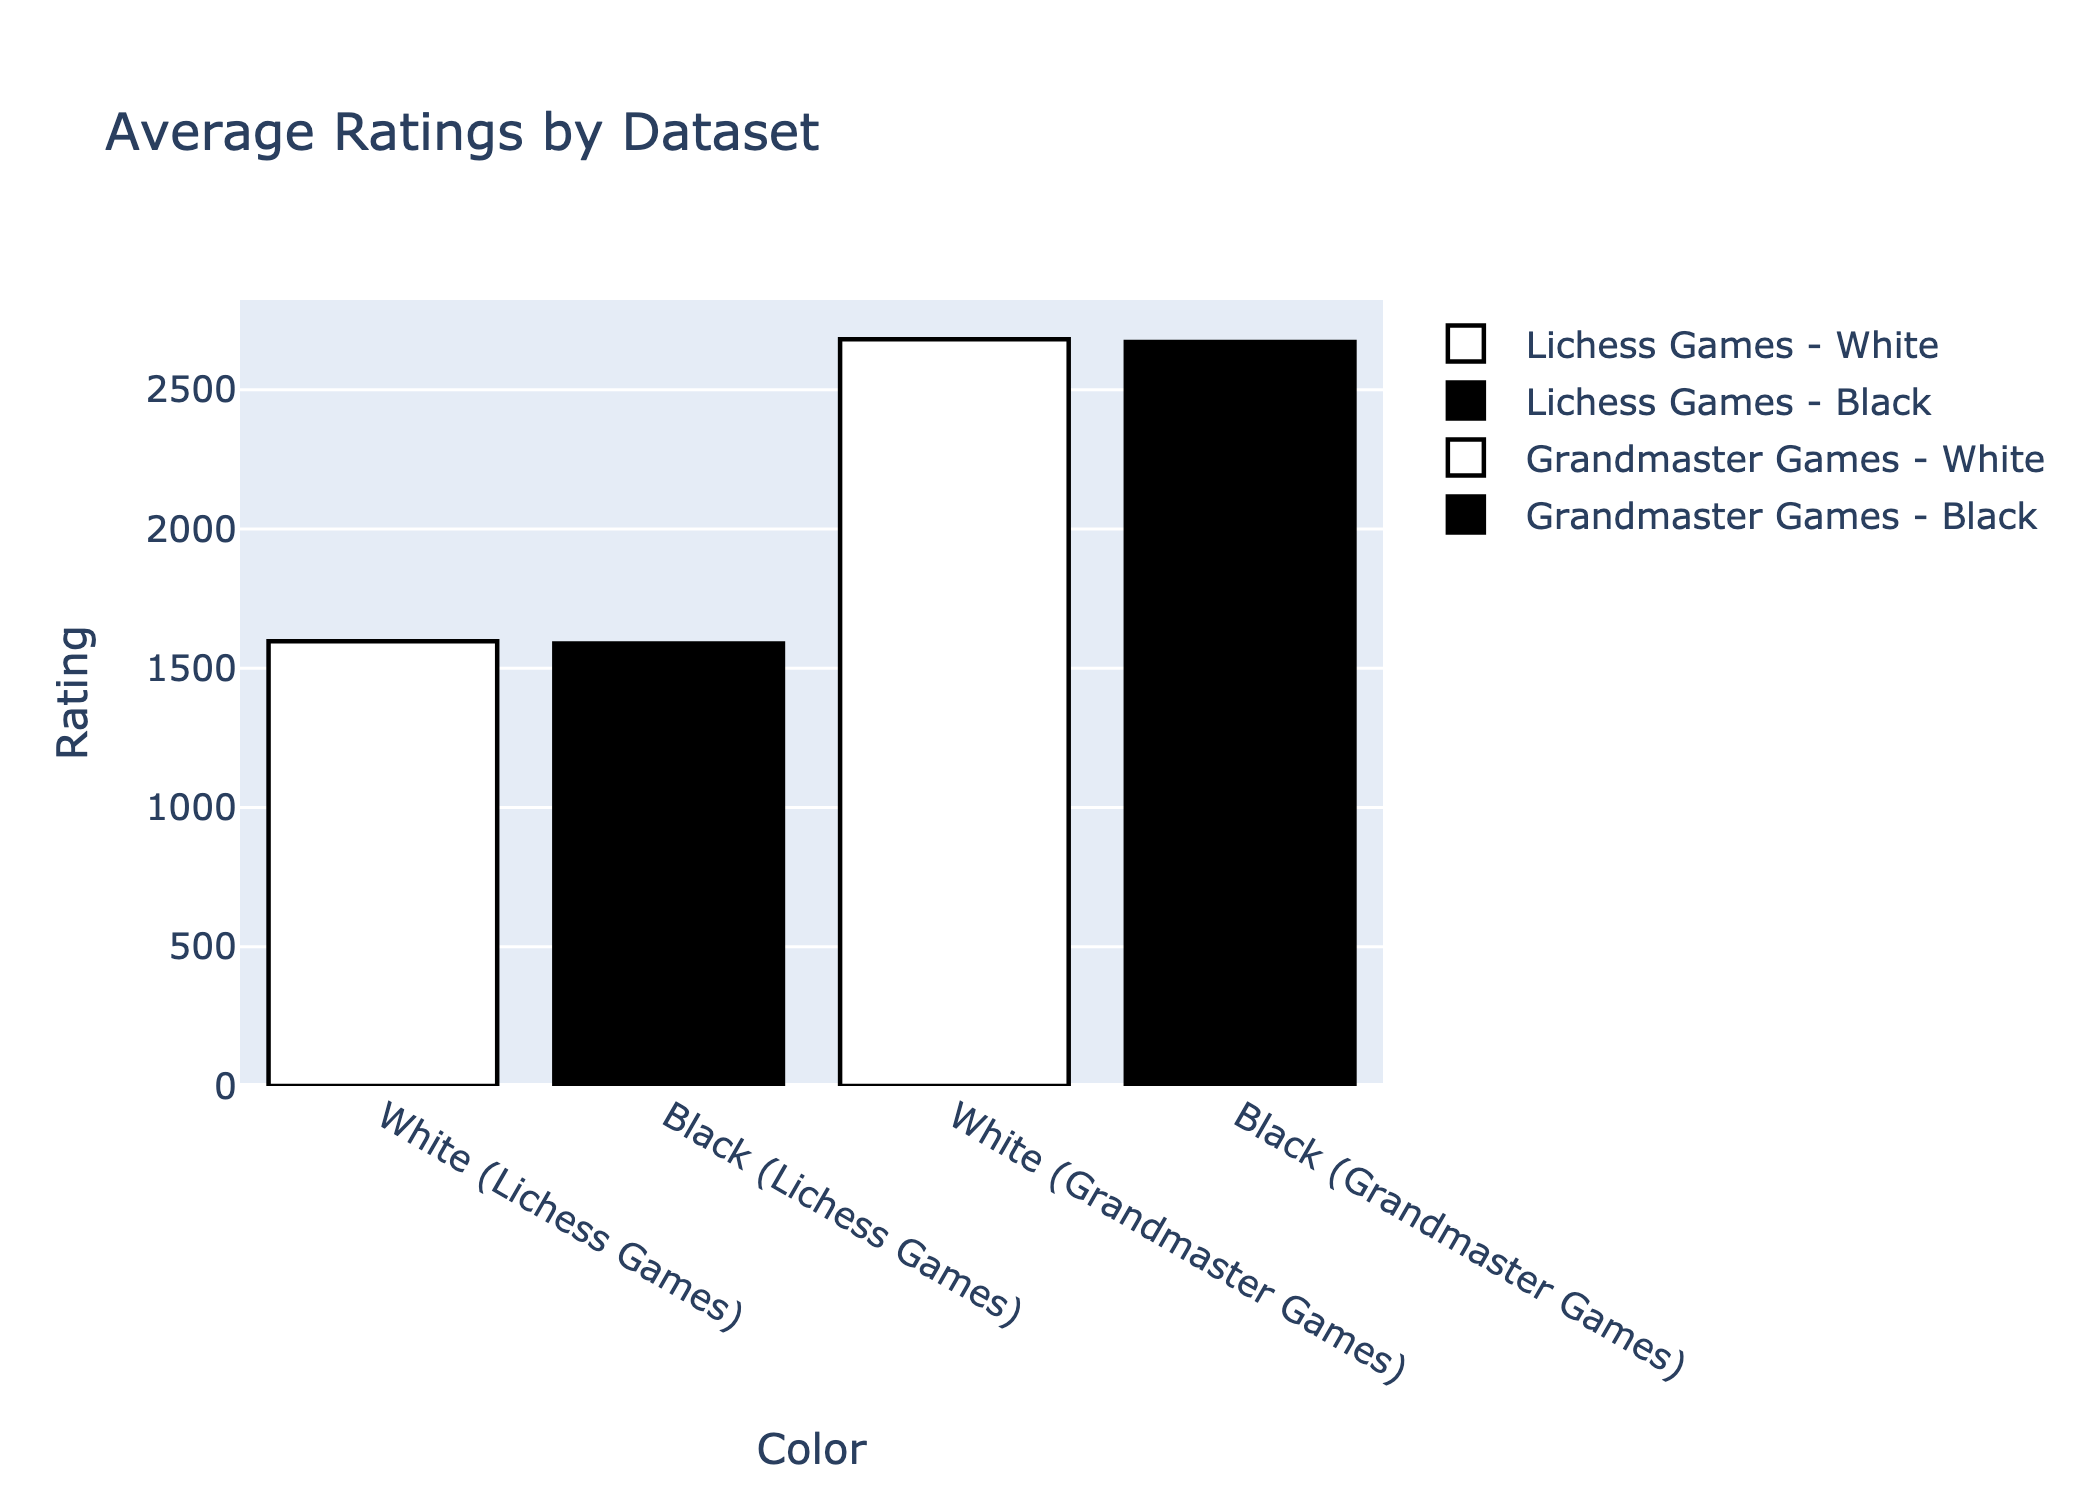

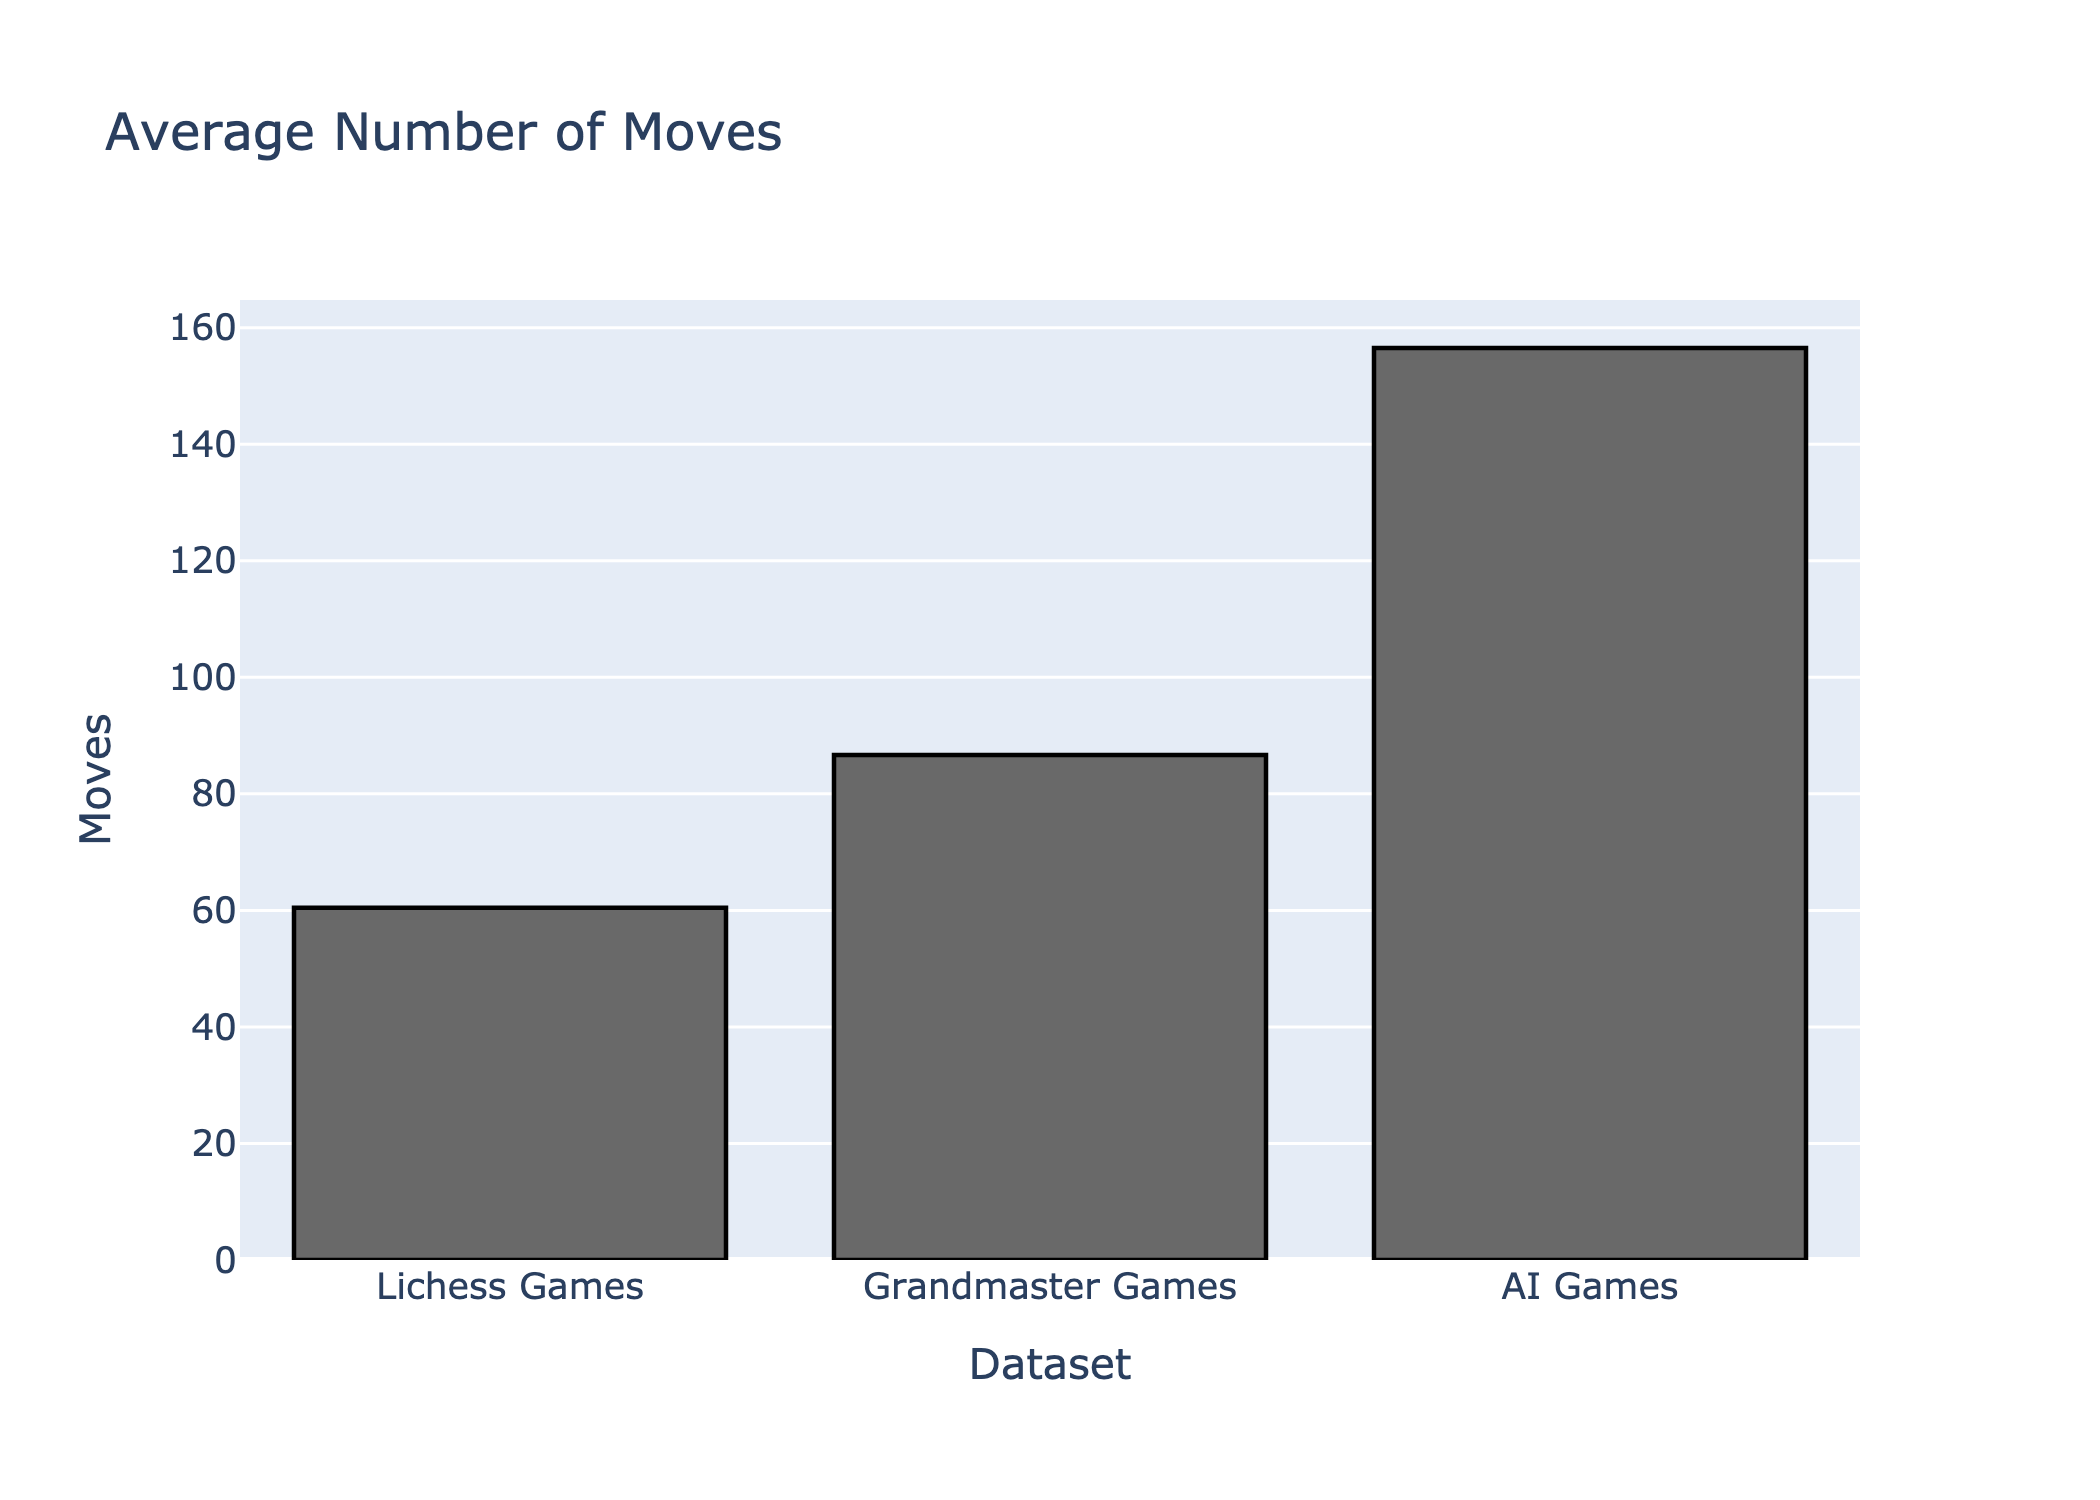

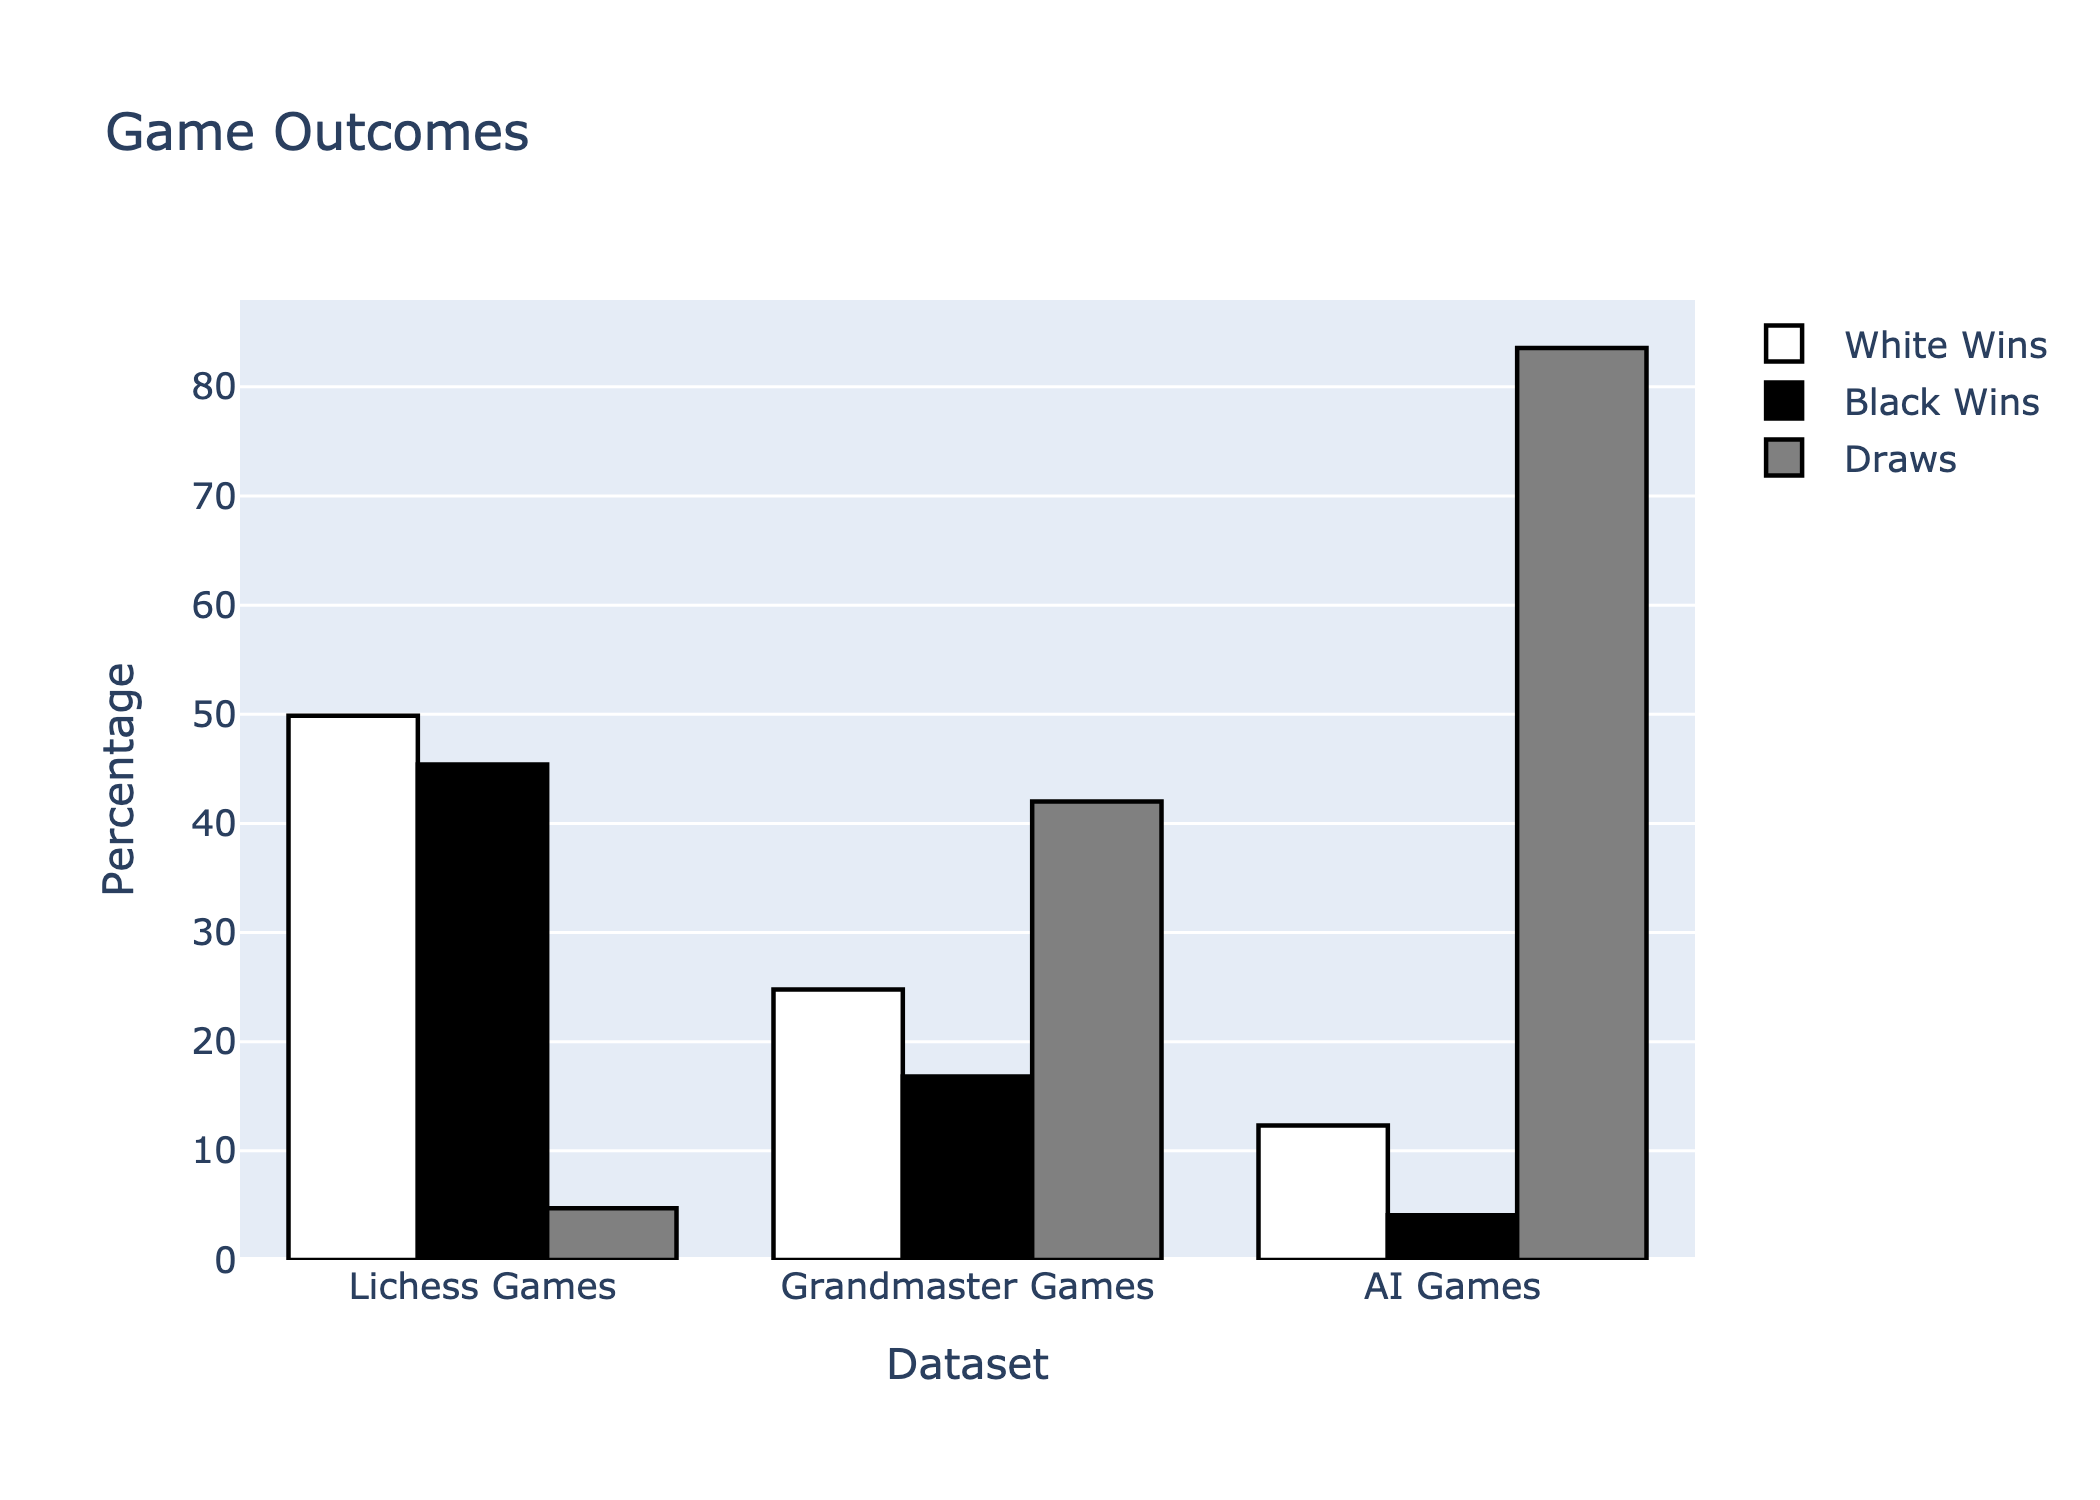

In [485]:
fig_ratings = go.Figure()
for dataset, color, rating in zip(ratings_combined['Dataset'], ratings_combined['Color'], ratings_combined['Rating']):
    bar_color = 'white' if color == 'White' else 'black'
    outline_color = 'black'
    fig_ratings.add_trace(go.Bar(
        x=[color + " (" + dataset + ")"],
        y=[rating],
        name=f"{dataset} - {color}",
        marker=dict(color=bar_color, line=dict(color=outline_color, width=1.5))
    ))

fig_ratings.update_layout(
    title="Average Ratings by Dataset",
    yaxis_title="Rating",
    xaxis_title="Color"
)

# Moves plot for all three datasets with grayscale and outline
fig_moves = px.bar(
    moves_df, 
    x="Dataset", 
    y="Average Moves", 
    title="Average Number of Moves",
    labels={"Average Moves": "Moves"},
    color_discrete_sequence=["dimgray", "gray", "lightgray"]
)
fig_moves.update_traces(marker_line_width=1.5, marker_line_color="black")

# Win percentage plot for all three datasets with grayscale and outline
fig_wins = go.Figure()
x = ['Lichess Games', 'Grandmaster Games', 'AI Games']
fig_wins.add_trace(go.Bar(
    x=x, 
    y=[wins_df1[0], wins_df2[0], wins_df3[0]], 
    name='White Wins',
    marker=dict(color='white', line=dict(color='black', width=1.5))
))
fig_wins.add_trace(go.Bar(
    x=x, 
    y=[wins_df1[1], wins_df2[1], wins_df3[1]], 
    name='Black Wins',
    marker=dict(color='black', line=dict(color='black', width=1.5))
))
fig_wins.add_trace(go.Bar(
    x=x, 
    y=[wins_df1[2], wins_df2[2], wins_df3[2]], 
    name='Draws',
    marker=dict(color='gray', line=dict(color='black', width=1.5))
))
fig_wins.update_layout(
    title="Game Outcomes",
    xaxis_title="Dataset",
    yaxis_title="Percentage",
    barmode="group"
)
fig_ratings.update_layout(showlegend=True)
fig_moves.update_layout(showlegend=True)
fig_wins.update_layout(showlegend=True)

# Display plots
fig_ratings.show()
fig_moves.show()
fig_wins.show()

Awesome, so we already have some pretty distinct different across the datasets:

1. Grandmaster average ranking is about 1,000 ELO higher than the Lichess player rankings

2. The average number of moves is higher in grandmaster games, and much higher in the AI games

3. The Average number of draws is 10x higher in the Grandmaster Games and 20x higher in the AI games. Also, the white-to-black win ratio increases.

These trends match onto the trends that we would expect to see as player ability increases, which we already saw within dataset 1. It'd be interesting to see the differences in those trends when player rankings are the same across the datasets, but on this scale of analysis, we can account for the majority of differences to be from differences in ability. 

To answer our final question, let's see how the number of moves is correlated to player ranking across the first two datasets. To make this more granular, let's see how this differs across the three most popular opening moves: e4, d4, and Nf3:

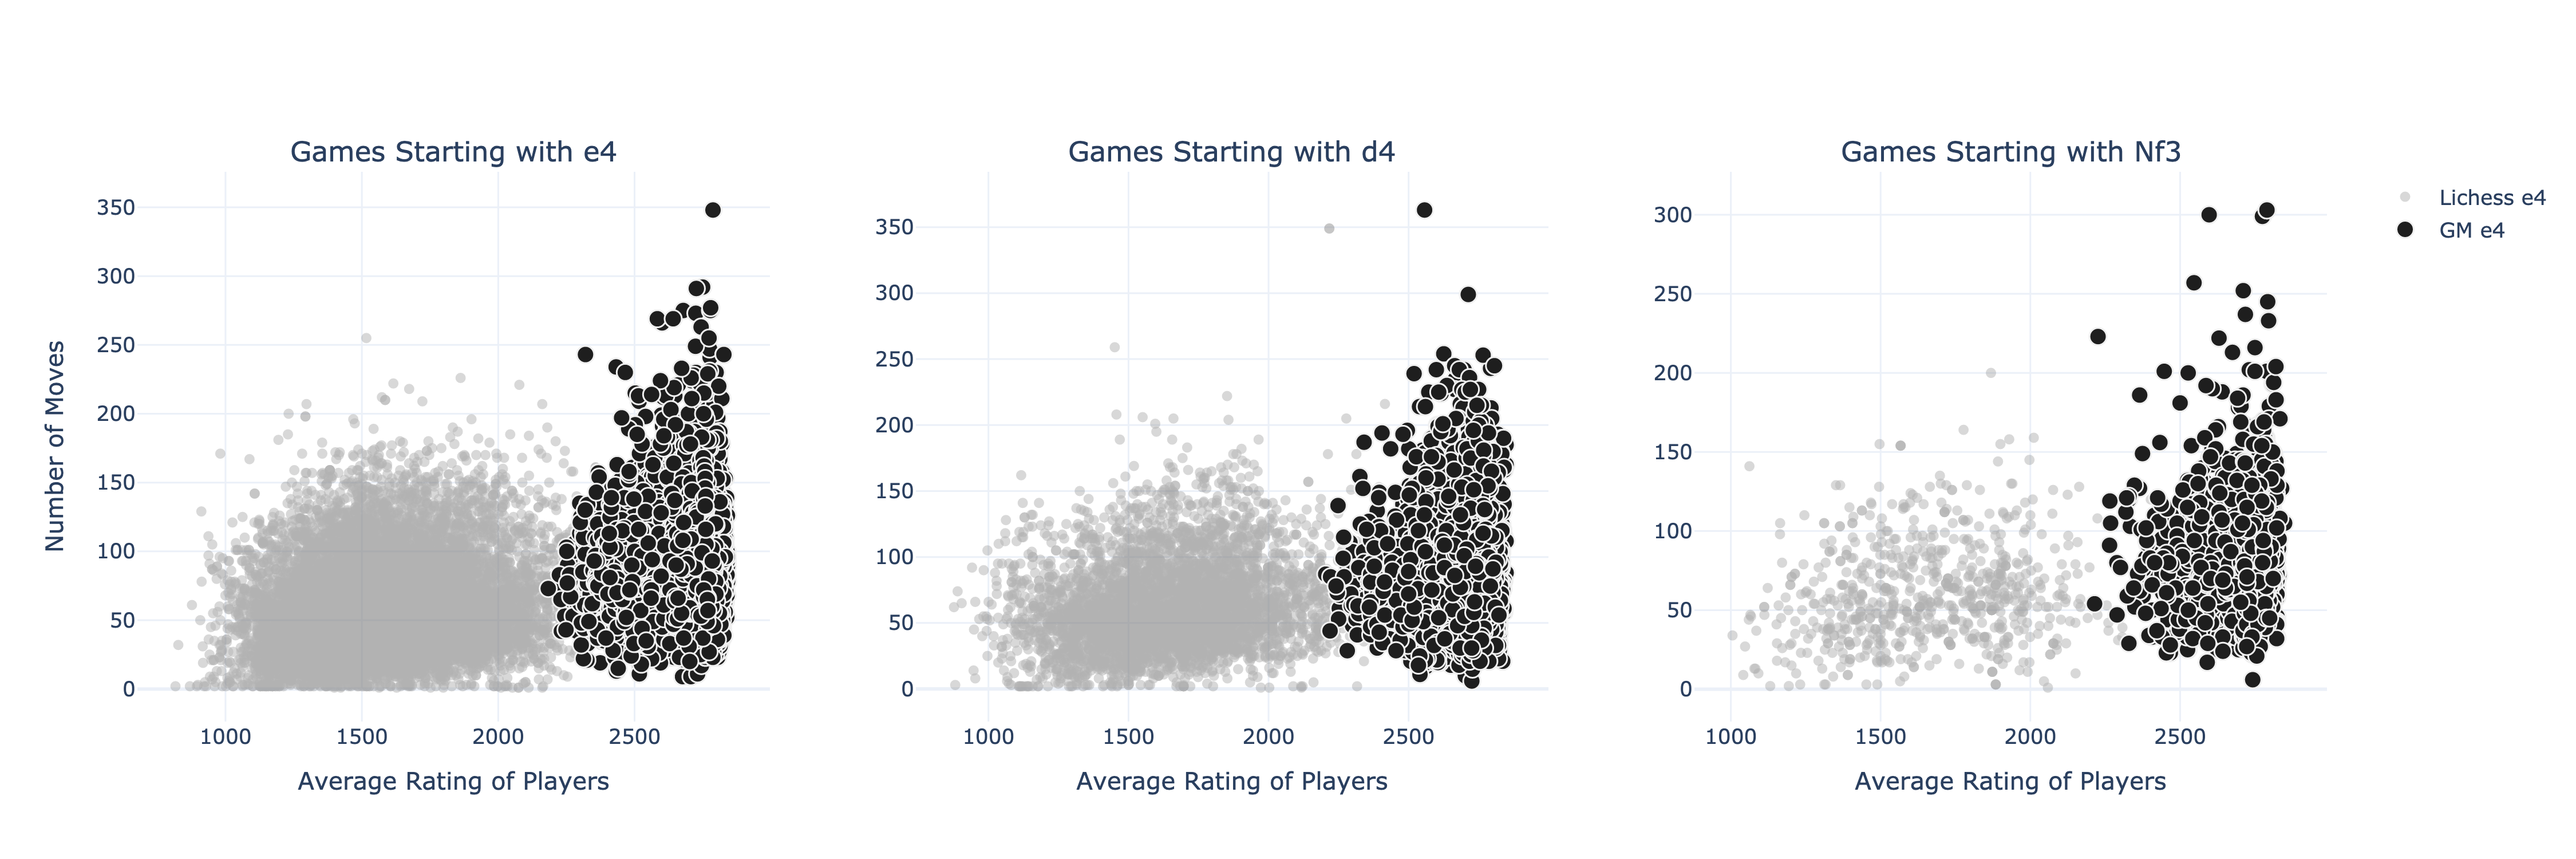

In [486]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Get 1st move for both datasets
def get_first_move(moves_str):
    try:
        return moves_str.split()[0]
    except:
        return None

# preparing data from both datasets
df['first_move'] = df['moves'].apply(get_first_move)
df['avg_rating'] = (df['white_rating'] + df['black_rating']) / 2
df['moves_length'] = df['moves'].str.count(' ') + 1

df2['first_move'] = df2['moves'].apply(get_first_move)
df2['avg_rating'] = (df2['white_rating'] + df2['black_rating']) / 2
df2['moves_length'] = df2['moves'].str.count(' ') + 1

#  figure w/ subplots
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=('Games Starting with e4', 'Games Starting with d4', 'Games Starting with Nf3')
)

# traces are added for each opening move
for idx, opening in enumerate(['e4', 'd4', 'Nf3']):
    # Lichess games
    df_opening = df[df['first_move'] == opening]
    fig.add_trace(
        go.Scatter(
            x=df_opening['avg_rating'],
            y=df_opening['moves_length'],
            mode='markers',
            name=f'Lichess {opening}',
            marker=dict(
                size=6,
                color='rgba(128, 128, 128, 0.5)',
                line=dict(width=0)
            ),
            opacity=0.6,
            showlegend=idx == 0 
        ),
        row=1, col=idx+1
    )
    
    
    df2_opening = df2[df2['first_move'] == opening]
    fig.add_trace(
        go.Scatter(
            x=df2_opening['avg_rating'],
            y=df2_opening['moves_length'],
            mode='markers',
            name=f'GM {opening}',
            marker=dict(
                size=10,
                color='rgba(30, 30, 30, 1)',
                line=dict(width=1, color='rgba(240, 240, 240, 1)')
            ),
            showlegend=idx == 0 
        ),
        row=1, col=idx+1
    )

fig.update_layout(
    height=500,
    width=1500,
    template='plotly_white',
    showlegend=True
)

for i in range(3):
    fig.update_xaxes(title_text="Average Rating of Players", row=1, col=i+1)
    fig.update_yaxes(title_text="Number of Moves" if i==0 else "", row=1, col=i+1)

fig.show()

It appears like, though there is a lot of variation at every level, rating does have a very slight--though consistent--correlation with the average number of moves. To confirm this, let's calculate their correlation and p-values:

In [487]:
from scipy import stats

openings = ["e4", "d4", "Nf3"]

def calculate_correlation_stats(data, opening=None):
    if opening:
        data = data[data['first_move'] == opening]
    if len(data) > 0:
        correlation, p_value = stats.pearsonr(data['avg_rating'], 
                                            data['moves_length'])
        n = len(data)
        return correlation, p_value, n
    return None, None, 0

print("Correlation Analysis between Average Rating and Game Length:")
print("\n{:<20} {:<20} {:<15} {:<15} {:<10}".format(
    "Dataset", "Opening Move", "Correlation", "P-value", "n Games"))
print("-" * 80)

# For Lichess Games
# First all games
correlation, p_value, n = calculate_correlation_stats(df)
print("{:<20} {:<20} {:<15.3f} {:<15.3e} {:<10}".format(
    "Lichess", "All Games", correlation, p_value, n
))
# Then by opening
for opening in openings:
    correlation, p_value, n = calculate_correlation_stats(df, opening)
    if correlation is not None:
        print("{:<20} {:<20} {:<15.3f} {:<15.3e} {:<10}".format(
            "Lichess", opening, correlation, p_value, n
        ))

print("\n")  # space between datasets


correlation, p_value, n = calculate_correlation_stats(df2)
print("{:<20} {:<20} {:<15.3f} {:<15.3e} {:<10}".format(
    "GM Games", "All Games", correlation, p_value, n
))

for opening in openings:
    correlation, p_value, n = calculate_correlation_stats(df2, opening)
    if correlation is not None:
        print("{:<20} {:<20} {:<15.3f} {:<15.3e} {:<10}".format(
            "GM Games", opening, correlation, p_value, n
        ))

Correlation Analysis between Average Rating and Game Length:

Dataset              Opening Move         Correlation     P-value         n Games   
--------------------------------------------------------------------------------
Lichess              All Games            0.161           7.048e-116      20058     
Lichess              e4                   0.153           1.008e-66       12598     
Lichess              d4                   0.182           5.257e-35       4522      
Lichess              Nf3                  0.124           8.114e-04       725       


GM Games             All Games            0.072           1.447e-19       15603     
GM Games             e4                   0.063           1.629e-08       8017      
GM Games             d4                   0.067           3.279e-06       4885      
GM Games             Nf3                  0.108           5.672e-05       1381      


The math backs this up! As we predicted, the correlation is relatively weak (below .17 for all rows), but the p-value is incredibly small, far below the 5% threshold. This means that, though the correlations aren't too large, we can say with a very high-degree of certainty that they are statistically real--not a result of noise or random variation. 

In GM games, the correlation seems to be slightly less large. This could be because the there's less variation in general, or it could be because, at extremely high-levels, the player rankings have a less of an overall impact (the correlation gets weaker). Still, it's reliably there. 

For lichess games, d4 games have the largest correlation between game length and player rankings; in GM games, Nf3 games actually have the largest correlations. While this could be explainable by the nature of the opening moves, I am inclined to believe that this is because of the datasize: of the top three openings, Nf3 has the largest correlation for Lichess games and the smallest for GM games--these extremes could likely be accounted for by the fact that its sample size is the smallest in both datasets, which always leads to more variation. 

<h2>Part Four: Model Exploration</h2>

In our model, we'll be predicting the rating of the player using a k-nearest neighbors mode. To do this, first, let's think about key metrics that we'll want to use:

1. The rating of the player's opponent
This could give a good indication of the player's skill level, but as we saw earlier, oftentimes, player are matched up against opponents of a different skill level. However, if also have variables that show which player won the game, this metric could be more useful.

2. The winnner / win status
The winner of the game, especially compared to the opponent's rating, will be the most important variables used for this model. The win status -- since draws and losses from time out have different implications for a player's rating -- will also be important. Plus, knowing the color of the winner and the loser could add addtional information.

3. The first move of the game
This could also be important as the first move is correlated with ranking, and there could be additional correlations when we work with the other variables.

To make this model, we will first:

a. Filter the data to only inlcude the top 4 most popular opening moves (less noise)

b. Filter the data by training and validation sets (90/10 split)

c. Run a k-nearest neighbors model. This model will:

* only looks at  with the the same first move, the same winner and loser, the same color, and the same win status 

* find the 5-nearest neigbhors based on the rating of their opponent. 

* use weighted averages of nearest neighbor ratings to predict the rating of the player.

* use the neigbhoors in the training set but will be evaluated on the validation set.

Finally, we'll compare metrics to a simpler model—-one that simply uses the average rating of the opponent—-to see if our more complex model is actually an improvement.

To learn more about k-nearest neighbors, I would recommend this resource: https://www.geeksforgeeks.org/k-nearest-neighbours/


First, let's create the features we'll need. In this cell, we'll:
 
* get the first move of the game by splitting the 'moves' string on whitespace and taking the first element [0]
 
* filter the data to only include the top 4 most common moves by using value_counts() to get move frequencies,
nlargest(4) to select top 4, and isin() to filter the dataframe
 
 * create the color and opponent rating columns using apply() with lambda functions:
   - player_color determined by comparing winner column to 'white'/'black'  
   - opponent_rating selected from white/black rating based on player's color


In [488]:
# Create features from our data
df_model = df.copy()

# Get first move
df_model['first_move'] = df_model['moves'].apply(lambda x: x.split()[0])

# top 4 most common first moves
top_moves = df_model['first_move'].value_counts().nlargest(4).index
df_model = df_model[df_model['first_move'].isin(top_moves)]

# Create color & opponent rating columns
df_model['player_color'] = df_model.apply(
    lambda row: 'white' if row['winner'] == 'white' else 'black', 
    axis=1
)
df_model['opponent_rating'] = df_model.apply(
    lambda row: row['black_rating'] if row['player_color'] == 'white' else row['white_rating'],
    axis=1
)
df_model['player_rating'] = df_model.apply(
    lambda row: row['white_rating'] if row['player_color'] == 'white' else row['black_rating'],
    axis=1
)

print("Dataset Statistics:")
print(f"Total games: {len(df_model):,}")
print("\nGames by first move:")
move_counts = df_model['first_move'].value_counts()
for move in move_counts.index:
    print(f"{move}: {move_counts[move]:,} games ({move_counts[move]/len(df_model)*100:.1f}%)")

Dataset Statistics:
Total games: 18,561

Games by first move:
e4: 12,598 games (67.9%)
d4: 4,522 games (24.4%)
Nf3: 725 games (3.9%)
c4: 716 games (3.9%)


The next cell defines a helper function `prepare_knn_data` that processes our chess game dataset for k-nearest neighbors analysis:

1. Creates a copy of the input dataframe to avoid SettingWithCopyWarning
2. Extracts the first move of each game by:
   - Using the 'moves' column which contains space-separated move strings
   - Applying a lambda function that splits on whitespace and takes first element [0]
   - Stores result in new 'first_move' column using .loc accessor
3. Filters to only include the 4 most common opening moves by:
   - Getting value counts of first moves
   - Taking top 4 with nlargest()
   - Using boolean indexing with isin() to filter dataframe
4. Creates a 'player_color' feature by:
   - Using .apply() with lambda function
   - Comparing 'winner' column to determine if player was white/black
   - Setting via .loc accessor

The function returns the filtered and feature-engineered dataframe ready for KNN analysis


In [489]:
def prepare_knn_data(df):
    """Prepare data for KNN analysis by filtering and creating features"""
    # Create a copy of the dataframe to avoid warnings
    df_copy = df.copy()
    
    # Get first move
    df_copy.loc[:, 'first_move'] = df_copy['moves'].apply(lambda x: x.split()[0])
    
    # Get top 4 most common moves
    top_moves = df_copy['first_move'].value_counts().nlargest(4).index
    df_filtered = df_copy[df_copy['first_move'].isin(top_moves)].copy()
    
    # Create features for matching
    df_filtered.loc[:, 'player_color'] = df_filtered.apply(
        lambda row: 'white' if row['winner'] == 'white' else 'black', axis=1
    )
    
    return df_filtered

The next function implements a k-nearest neighbors approach for finding similar chess games:

1. Input parameters:
   - `target_game`: A single game record to find matches for
   - `training_data`: DataFrame containing the pool of games to search through
   - `k`: Number of nearest neighbors to return (default=10)

2. Filtering matches:
   - Creates a subset of games matching the target game's:
     - First move (e.g. 'e4')
     - Player color (white/black) 
     - Game outcome (win/loss/draw)
   - Uses boolean indexing with & operator to combine multiple conditions
   - Creates a copy to avoid SettingWithCopyWarning

3. Rating difference calculation:
   - For each matching game, calculates absolute difference between:
     - Opponent rating in the match game
     - Opponent rating in the target game
   - Uses .loc accessor to add 'rating_diff' column

4. Neighbor selection:
   - Uses .nsmallest() to get k games with smallest rating differences
   - Returns DataFrame containing the k nearest neighbor games


In [490]:
def find_nearest_neighbors(target_game, training_data, k=10):
    """Find k nearest neighbors based on matching criteria and rating difference"""
    # Match games with same first move and same winner
    matches = training_data[
        (training_data['first_move'] == target_game['first_move']) &
        (training_data['winner'] == target_game['winner'])
    ].copy()
    
    if len(matches) < k:
        return None
    
    # Calculate rating differences (now always using black's rating as opponent)
    target_opp_rating = target_game['black_rating']
    matches.loc[:, 'rating_diff'] = abs(matches['black_rating'] - target_opp_rating)
    
    # Get k nearest neighbors
    neighbors = matches.nsmallest(k, 'rating_diff')
    return neighbors

The `predict_rating()` function below implements weighted k-nearest neighbors to predict player ratings:

1. Input validation:
   - Checks if neighbors DataFrame exists and has data
   - Returns None if no valid neighbors

2. Weight calculation:
   - Uses inverse distance weighting: 1/(rating_diff + 1)
   - Adding 1 prevents division by zero
   - Closer neighbors get higher weights

3. Rating extraction:
   - Gets player rating from each neighbor game based on color played
   - Uses DataFrame.apply() to select correct rating column

4. Final prediction:
   - Calculates weighted average of neighbor ratings
   - Returns this as the predicted rating



In [491]:
def predict_rating(neighbors):
    """Predict rating using weighted average of neighbors"""
    if neighbors is None or len(neighbors) == 0:
        return None
        
    weights = 1 / (neighbors['rating_diff'] + 1)  # Add 1 to avoid division by zero
    ratings = neighbors.apply(
        lambda x: x['white_rating'] if x['player_color'] == 'white' else x['black_rating'],
        axis=1
    )
    
    return (ratings * weights).sum() / weights.sum()

The next cell evaluates our k-nearest neighbors model on a validation set. It splits our data into training (90%) and validation (10%) sets using scikit-learn's train_test_split.

For each game in the validation set, the code:
1. Finds similar games from the training data
2. Uses these similar games to predict the player's rating
3. Stores both the predicted and actual ratings

This process lets us measure how accurate our model is by comparing its predictions to known ratings on games it hasn't seen before.



In [492]:
# Prepare data
from sklearn.model_selection import train_test_split

df_knn = prepare_knn_data(df)
train_data, val_data = train_test_split(df_knn, test_size=0.1, random_state=42)

# Make predictions on validation set
predictions = []
actual_ratings = []

for _, game in val_data.iterrows():
    neighbors = find_nearest_neighbors(game, train_data)
    predicted_rating = predict_rating(neighbors)
    
    if predicted_rating is not None:
        predictions.append(predicted_rating)
        actual_ratings.append(
            game['white_rating'] if game['player_color'] == 'white' else game['black_rating']
        )

The next cell calculates and compares performance metrics between our k-nearest neighbors model and a simple baseline model.

For the KNN model, it calculates absolute differences between predicted and actual ratings, then computes several metrics:
- Percentage of predictions within 100/200/300 rating points
- Median absolute error (robust to outliers)
- Mean absolute error (standard accuracy measure)

To validate the KNN model's value, it compares against a basic baseline that simply predicts each player's rating to be equal to their opponent's rating. This comparison helps us understand if the more complex KNN approach actually provides meaningful improvements over simple heuristics.

The cell outputs a comparison table and calculates improvement percentages to measure how much better the KNN model performs than the baseline, helping justify whether its additional complexity is worthwhile.



In [493]:
differences = np.abs(np.array(predictions) - np.array(actual_ratings))
metrics = {
    'within_100': np.mean(differences <= 100) * 100,
    'within_200': np.mean(differences <= 200) * 100,
    'within_300': np.mean(differences <= 300) * 100,
    'median_error': np.median(differences),
    'mean_error': np.mean(differences)
}

# Simple baseline model: predict rating based on opponent's rating
baseline_predictions = []
baseline_actuals = []

for _, game in val_data.iterrows():
    # Get opponent rating
    opponent_rating = game['black_rating'] if game['player_color'] == 'white' else game['white_rating']
    baseline_predictions.append(opponent_rating)
    
    # Get actual rating
    actual_rating = game['white_rating'] if game['player_color'] == 'white' else game['black_rating']
    baseline_actuals.append(actual_rating)

# Calculate baseline metrics
baseline_differences = np.abs(np.array(baseline_predictions) - np.array(baseline_actuals))
baseline_metrics = {
    'within_100': np.mean(baseline_differences <= 100) * 100,
    'within_200': np.mean(baseline_differences <= 200) * 100,
    'within_300': np.mean(baseline_differences <= 300) * 100,
    'median_error': np.median(baseline_differences),
    'mean_error': np.mean(baseline_differences)
}

# Print comparison
print("Model Comparison:\n")
print("Metric                  KNN Model    Baseline Model")
print("-" * 50)
print(f"Within 100 points:     {metrics['within_100']:8.1f}%    {baseline_metrics['within_100']:8.1f}%")
print(f"Within 200 points:     {metrics['within_200']:8.1f}%    {baseline_metrics['within_200']:8.1f}%")
print(f"Within 300 points:     {metrics['within_300']:8.1f}%    {baseline_metrics['within_300']:8.1f}%")
print(f"Median absolute error: {metrics['median_error']:8.1f}    {baseline_metrics['median_error']:8.1f}")
print(f"Mean absolute error:   {metrics['mean_error']:8.1f}    {baseline_metrics['mean_error']:8.1f}")

# Calculate improvement percentages
improvements = {
    'within_100': ((metrics['within_100'] - baseline_metrics['within_100']) / baseline_metrics['within_100']) * 100,
    'within_200': ((metrics['within_200'] - baseline_metrics['within_200']) / baseline_metrics['within_200']) * 100,
    'within_300': ((metrics['within_300'] - baseline_metrics['within_300']) / baseline_metrics['within_300']) * 100,
    'median_error': ((baseline_metrics['median_error'] - metrics['median_error']) / baseline_metrics['median_error']) * 100,
    'mean_error': ((baseline_metrics['mean_error'] - metrics['mean_error']) / baseline_metrics['mean_error']) * 100
}

print("\nKNN Model Improvements:")
print(f"Improvement in within 100: {improvements['within_100']:+.1f}%")
print(f"Improvement in within 200: {improvements['within_200']:+.1f}%")
print(f"Improvement in within 300: {improvements['within_300']:+.1f}%")
print(f"Improvement in median error: {improvements['median_error']:+.1f}%")
print(f"Improvement in mean error: {improvements['mean_error']:+.1f}%")

Model Comparison:

Metric                  KNN Model    Baseline Model
--------------------------------------------------
Within 100 points:         69.9%        47.7%
Within 200 points:         85.2%        70.2%
Within 300 points:         92.7%        83.0%
Median absolute error:      8.2       107.0
Mean absolute error:       82.6       165.4

KNN Model Improvements:
Improvement in within 100: +46.7%
Improvement in within 200: +21.5%
Improvement in within 300: +11.6%
Improvement in median error: +92.3%
Improvement in mean error: +50.1%


**Results:**

Our KNN model significantly outperforms the baseline model across all metrics. Let's analyze the specific improvements:

**Accuracy Within Rating Ranges:**
- Within 100 points: Our model correctly predicts 69.9% of ratings within 100 points, compared to the baseline's 47.7% - a substantial 46.7% improvement
- Within 200 points: 85.2% accuracy vs 70.2% baseline (21.5% improvement)
- Within 300 points: 92.7% accuracy vs 83.0% baseline (11.6% improvement)

**Error Metrics:**
- Median absolute error: Our model achieves an impressive 8.2 points vs the baseline's 107.0 points - a 92.3% reduction in error
- Mean absolute error: 82.6 points vs 165.4 points baseline (50.1% improvement)

The stark difference between our model's median error (8.2) and mean error (82.6) suggests the presence of outliers that are skewing the mean higher. This could be attributed to several factors:
1. New players with provisional ratings (often starting at 1500) whose true skill level isn't yet reflected in their rating
2. Players who are rapidly improving or declining in skill
3. Games with unusual patterns that don't fit the typical relationships our model has learned

Despite these outlier cases, our model demonstrates strong predictive power, successfully leveraging multiple features (opponent's rating, game winner, winner's color, and opening move) to achieve significantly better predictions than simply using the opponent's rating alone. The high accuracy within 300 points (92.7%) and the dramatic reduction in median error (92.3% improvement) particularly highlight the model's effectiveness.
